## FIRST STEP:
##### -Import your libraries

##### -Take a subset of the data for signal analysis

##### -Perfom Data Preprocessing

## Importing libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import mne
import shutil
import glob
from scipy.signal import welch
from itertools import permutations
from collections import Counter
from mne.preprocessing import annotate_amplitude
import seaborn as sns
from mne.io import read_raw_eeglab
from mne.viz import plot_sensors
from mne.io import read_raw_fif
from joblib import Parallel, delayed
import time
import networkx as nx
from EntropyHub import ApEn, SampEn, PermEn


/Users/folasewaabdulsalam/Signal_Processing/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#a quick check of the raw data
raw_data_path = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_dataset/sub-001/eeg/sub-001_task-eyesclosed_eeg.set"

raw_data = mne.io.read_raw_eeglab(raw_data_path, preload=True)

print (raw_data.info)
raw_data.plot()

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>


In [ ]:
#copying the interested subjects 1 to 65 from preprocessed data to filtered subjects

source_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_dataset"
target_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects"

for subject_id in range (1, 66):
    subject_folder = f"sub-{str(subject_id).zfill(3)}" #the format is in sub-001
    source_path = os.path.join(source_folder, subject_folder, "eeg", f"{subject_folder}_task-eyesclosed_eeg.set")

    if os.path.exists(source_path):
        shutil.copy(source_path, target_folder)
    else:
        print(f"File not found {source_path}")

## Signal Analysis

In [3]:
subject_path = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects"
set_files = glob.glob(f"{subject_path}/*.set")
filtered_output_preprocessed = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed"

#### The Preprocess function does the following:
#### -Loads the data
#### -EEG referencing
#### -Band-pass filtering
#### -Noise detection
#### -Noice removal via ICA
#### -ASR-based Artifact Rejection (annotations created to flag bad segments)
#### -Bad segment handling
#### -Saving the preprocessed file

In [6]:
channel_stds = raw_data.get_data().std(axis=1)
max_std = channel_stds.mean()
print(max_std)

3.18252772217784e-05


In [7]:
def preprocess_file(set_path, output_path, n_components=19, noise_threshold=6e-5):
    """
    Preprocess an EEG file with optional noise detection, ICA, and ASR.

    Parameters:
    - set_path: Path to the input .set file.
    - output_path: Path to save the preprocessed file.
    - n_components: Number of components for ICA.
    - noise_threshold: Noise threshold in volts (default is 30 µV, converted to volts).
    """
    print(f"Processing file: {set_path}")

   #this loads the raw .set file since eeglab format for eeg is .set
    raw_dataset = mne.io.read_raw_eeglab(set_path, preload=True) 

   #the reference electrodes A1 and A2 were absent, hence average re-referencing was done
    print("Applying average re-referencing...")
    raw_dataset.set_eeg_reference(ref_channels="average") 

   #a band-pass filter of 0.5 to 45Hz was applied
    print("Applying band-pass filter 0.5Hz to 45Hz...") 
    raw_dataset.filter(l_freq=0.5, h_freq=45)

    # this checks for noise in the signal
    print("Checking for noise in the data...") 
    # standard deviation is computed for each channela nd its max is taken for comparison
    channel_stds = raw_dataset.get_data().std(axis=1)
    max_std = channel_stds.max()

    # If noise detected, apply ICA
    if max_std > noise_threshold:
        print(f"Noise detected! Maximum channel std: {max_std:.2e} V. Applying ICA...")

        # Perform ICA to remove artifacts
        ica = mne.preprocessing.ICA(n_components=n_components, random_state=42, max_iter="auto")
        ica.fit(raw_dataset)
        #this automatically excludes the artifacts if found
        ica.exclude = []  
        raw_dataset = ica.apply(raw_dataset)

    else:
        print(f"No significant noise detected (max std: {max_std:.2e} V). Skipping ICA.")

    # Apply ASR for automatic artifact rejection
    print("Applying Artifact Subspace Reconstruction (ASR)...")

    # Annotate bad segments based on the amplitude threshold
    annotations, _ = annotate_amplitude(
        raw_dataset,
        peak=17e-6,  # threshold for detecting artifacts
        min_duration=0.5,  # Minimum artifact duration (0.5 seconds)
    )
    raw_dataset.set_annotations(annotations) # annotations added to the dataset to mark bad data for exclusion

    # Exclude bad segments manually
    print("Excluding bad segments...")
    good_data = raw_dataset.get_data()
    for annotation in raw_dataset.annotations:
        onset_sample = int(annotation['onset'] * raw_dataset.info['sfreq']) #this gets the start of the bad segment
        duration_sample = int(annotation['duration'] * raw_dataset.info['sfreq']) #this gets the length of the bad segment
        good_data[:, onset_sample:onset_sample + duration_sample] = np.nan  # slices the data for the time range and marks bad segments as NaN

    # creating a cleaned copy of the data
    raw_dataset_clean = raw_dataset.copy()
    raw_dataset_clean._data = np.nan_to_num(good_data, nan=0.0)  # Replacing the Nans with zeroes

    # Save the preprocessed file
    output_file = os.path.join(output_path, os.path.basename(set_path).replace(".set", "_preprocessed.fif"))
    print(f"Saving the preprocessed file to: {output_file}")
    raw_dataset_clean.save(output_file, overwrite=True)


In [9]:

Parallel(n_jobs=-1)(
delayed(preprocess_file)(file, filtered_output_preprocessed)
for file in set_files
)

Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-062_task-eyesclosed_eeg.set
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-022_task-eyesclosed_eeg.set
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-053_task-eyesclosed_eeg.set
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-013_task-eyesclosed_eeg.set
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-031_task-eyesclosed_eeg.set
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-040_task-eyesclosed_eeg.set
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-017_task-eyesclosed_eeg.set
Processing fi

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average re-referencing...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
Applying average re-referencing...
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s


Applying band-pass filter 0.5Hz to 45Hz...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Checking for noise in the data...
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


Noise detected! Maximum channel std: 1.69e-05 V. Applying ICA...
Applying band-pass filter 0.5Hz to 45Hz...
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s


Noise detected! Maximum channel std: 1.42e-05 V. Applying ICA...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Checking for noise in the data...
Checking for noise in the data...
Noise detected! Maximum channel std: 1.83e-05 V. Applying ICA...
Checking for noise in the data...
Checking for noise in the data...
Noise detected! Maximum channel std: 1.21e-05 V. Applying ICA...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s


Noise detected! Maximum channel std: 1.13e-05 V. Applying ICA...
Noise detected! Maximum channel std: 1.35e-05 V. Applying ICA...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Checking for noise in the data...
Checking for noise in the data...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Noise detected! Maximum channel std: 2.18e-05 V. Applying ICA...
Noise detected! Maximum channel std: 1.49e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Selecting by number: 19 components
Selecting by number: 19 components
Selecting by number: 19 components
Selecting by n

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.6) and smallest (1.7e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Fitting ICA took 55.6s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-029_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-029_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-029_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-029_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-058_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.5) and smallest (1.3e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Fitting ICA took 65.5s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Checking for noise in the data...
Noise detected! Maximum channel std: 1.19e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Excluding bad segments...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (6) and smallest (7.6e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-062_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-062_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-062_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Fitting ICA took 67.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-062_task-eyesclosed_eeg_preprocessed.fif
[done]
Excluding bad segments...
Selecting by number: 19 components
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-013_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-013_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-013_task-eyesclosed_eeg_preprocessed.fif
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-057_task-eyesclosed_eeg.set
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.5) and smallest (1.4e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-013_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-026_task-eyesclosed_eeg.set
Fitting ICA took 73.6s.
Applying ICA to Raw instance
    Transforming to ICA space (19 component

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Checking for noise in the data...
Noise detected! Maximum channel std: 1.09e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Excluding bad segments...
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Saving the preprocessed file to: /Users/f

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-022_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-022_task-eyesclosed_eeg_preprocessed.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-022_task-eyesclosed_eeg_preprocessed.fif
[done]
Checking for noise in the data...
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-018_task-eyesclosed_eeg.set
Noise detected! Maximum channel std: 1.82e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


Checking for noise in the data...
Selecting by number: 19 components
Noise detected! Maximum channel std: 1.16e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (10) and smallest (7.5e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.5) and smallest (2e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Fitting ICA took 85.0s.
Applying ICA to Raw instance
Fitting ICA took 86.6s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Transforming to ICA space (19 components)
    Projecting back using 19 PCA components
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Applying Artifact Subspace Reconstruction (ASR)...
Selecting by number: 19 components
Finding segments below or above PTP threshold.
Excluding bad segments...
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-017_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-017_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-017_task-eyesclosed_eeg_preprocessed.fif
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-040_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-040_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-040_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-017_task-eyesclosed_eeg_preprocessed.fif
[done]
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-040_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-035_task-eyesclosed_eeg.set
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-044_task-eyesclosed_eeg.set
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Checking for noise in the data...
Noise detected! Maximum channel std: 1.10e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


Checking for noise in the data...
Noise detected! Maximum channel std: 1.21e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.7) and smallest (1.1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Selecting by number: 19 components
Fitting ICA took 101.5s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-053_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-053_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-053_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-053_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-004_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Checking for noise in the data...
Noise detected! Maximum channel std: 1.14e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.4) and smallest (1.8e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Fitting ICA took 116.2s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-031_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-031_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-031_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.9) and smallest (8e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Fitting ICA took 29.1s.
Applying ICA to Raw instance
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-031_task-eyesclosed_eeg_preprocessed.fif
[done]
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.1) and smallest (4.4e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-008_task-eyesclosed_eeg.set
Excluding bad segments...
Fitting ICA took 59.2s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-035_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-035_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Applying Artifact Subspace Reconstruction (ASR)...
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-035_task-eyesclosed_eeg_preprocessed.fif
Finding segments below or above PTP threshold.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-035_task-eyesclosed_eeg_preprocessed.f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-058_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-058_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-058_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
Checking for noise in the data...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Noise detected! Maximum channel std: 1.74e-05 V. Applying ICA...
Applying band-pass filter 0.5Hz to 45Hz...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-058_task-eyesclosed_eeg_preprocessed.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwid

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Checking for noise in the data...
Noise detected! Maximum channel std: 1.02e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Checking for noise in the data...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.2) and smallest (5.6e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Noise detected! Maximum channel std: 1.72e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Fitting ICA took 60.7s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Selecting by number: 19 components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (5.4) and smallest (7.4e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16


Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-057_task-eyesclosed_eeg_preprocessed.fif
Selecting by number: 19 components
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-057_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-057_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Fitting ICA took 60.6s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-057_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-048_task-eyesclosed_eeg.set
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-026_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-026_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-026_task-eyesclosed_eeg_preprocessed.fif
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preproc

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Checking for noise in the data...
Noise detected! Maximum channel std: 2.77e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.5) and smallest (1.1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Checking for noise in the data...
Noise detected! Maximum channel std: 1.26e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Fitting ICA took 67.7s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-018_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-018_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-018_task-eyesclosed_eeg_preprocessed.fif
Selecting by number: 19 components
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-018_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-007_task-eyesclosed_eeg.set
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (5.8) and smallest (1.1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (12) and smallest (9.9e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Fitting ICA took 50.5s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


Fitting ICA took 64.4s.
Applying ICA to Raw instance
Checking for noise in the data...
Excluding bad segments...
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Noise detected! Maximum channel std: 8.07e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Applying Artifact Subspace Reconstruction (ASR)...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-004_task-eyesclosed_eeg_preprocessed.fif
Finding segments below or above PTP threshold.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-004_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-004_task-eyesclosed_eeg_preprocessed.fif
Excluding bad segments...
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-004_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-014_task-eyesclosed_eeg.set
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-044_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-044_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-044_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Selecting by number: 19 components
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-044_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Proces

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Checking for noise in the data...
Noise detected! Maximum channel std: 2.43e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s


Checking for noise in the data...
Noise detected! Maximum channel std: 7.84e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.4) and smallest (7.5e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Fitting ICA took 59.6s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-047_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-047_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-047_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.8) and smallest (1.4e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-047_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-054_task-eyesclosed_eeg.set
Fitting ICA took 47.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying Artifact Subspace Reconstruction (ASR)...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Finding segments below or above PTP threshold.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-039_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-039_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-039_task-eyesclosed_eeg_preprocessed.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


Checking for noise in the data...
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-039_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-025_task-eyesclosed_eeg.set
Noise detected! Maximum channel std: 1.22e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.5) and smallest (1.2e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Fitting ICA took 75.4s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments bel

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Excluding bad segments...
Checking for noise in the data...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.3) and smallest (4.2e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Selecting by number: 19 components
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-008_task-eyesclosed_eeg_preprocessed.fif
Noise detected! Maximum channel std: 1.26e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-008_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-008_task-eyesclosed_eeg_preprocessed.fif
Fitting ICA took 33.2s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.3) and smallest (8.1e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16


Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-008_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-003_task-eyesclosed_eeg.set
Excluding bad segments...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.3) and smallest (3.4e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Fitting ICA took 77.3s.
Applying ICA to Raw instance
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-065_task-eyesclosed_eeg_preprocessed.fif
    Transforming to 

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-065_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-065_task-eyesclosed_eeg_preprocessed.fif
Checking for noise in the data...
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Noise detected! Maximum channel std: 1.11e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Selecting by number: 19 components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Selecting by number: 19 components
Excluding bad segments...
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-065_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-007_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-007_task-eyesclosed_eeg_preprocessed.fif
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-036_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-036_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-036_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-007_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-043_task-eyesclosed_eeg.set
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.5s
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Checking for noise in the data...
Noise detected! Maximum channel std: 7.77e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Checking for noise in the data...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Noise detected! Maximum channel std: 1.11e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Checking for noise in the data...
Noise detected! Maximum channel std: 1.90e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.5) and smallest (1.5e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Fitting ICA took 18.6s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-003_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-003_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-003_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-003_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-021_task-eyesclosed_eeg.set
Selecting by number: 19 components
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.8) and smallest (7.9e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (10) and smallest (7.4e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Fitting ICA took 64.9s.
Applying ICA to Raw instance
Fitting ICA took 88.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Checking for noise in the data...
Noise detected! Maximum channel std: 8.48e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
    Transforming to ICA space (19 components)
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-014_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-014_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-014_task-eyesclosed_eeg_preprocessed.fif
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-048_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-048_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-048_task-eyesclosed_eeg_preprocessed.fif
Selecting by number: 19 components
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-014_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-010_task-eyesclosed_eeg.set
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-048_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-061_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Applying average re-referencing...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

EEG channel type selected for re-referencing
FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
Applying average reference.
Applying a custom ('EEG',) reference.
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s


Checking for noise in the data...
Noise detected! Maximum channel std: 1.85e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Checking for noise in the data...
No significant noise detected (max std: 5.49e-06 V). Skipping ICA.
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Selecting by number: 19 components
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-010_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-010_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-010_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-010_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-005_task-eyesclosed_eeg.set
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 5

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


Checking for noise in the data...
Noise detected! Maximum channel std: 1.09e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (8) and smallest (8.8e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Selecting by number: 19 components
Fitting ICA took 57.0s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-025_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-025_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-025_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-025_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-045_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.7) and smallest (1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Fitting ICA took 65.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments bel

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-054_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-054_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-054_task-eyesclosed_eeg_preprocessed.fif
Checking for noise in the data...
Noise detected! Maximum channel std: 1.33e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-054_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-034_task-eyesclosed_eeg.set
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Selecting by number: 19 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Checking for noise in the data...
Noise detected! Maximum channel std: 7.96e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (12) and smallest (1.1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Fitting ICA took 33.4s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-061_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-061_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-061_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.1) and smallest (1.7e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16


Fitting ICA took 66.4s.
Applying ICA to Raw instance
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-061_task-eyesclosed_eeg_preprocessed.fif
[done]
    Transforming to ICA space (19 components)
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-019_task-eyesclosed_eeg.set
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Excluding bad segments...
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-032_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-032_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-032_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-032_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-027_task-eyesclosed_eeg.set


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Checking for noise in the data...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (4.4) and smallest (3.1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Noise detected! Maximum channel std: 9.23e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Fitting ICA took 38.5s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.8) and smallest (7e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Checking for noise in the data...
Excluding bad segments...
Noise detected! Maximum channel std: 1.77e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-005_task-eyesclosed_eeg_preprocessed.fif
Fitting ICA took 74.5s.
Applying ICA to Raw instance
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-005_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-005_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Selecting by number: 19 components
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-005_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-056_task-eyesclosed_eeg.set
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-050_task-eyesclosed_eeg_preprocessed.fif
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-050_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (7) and smallest (1.7e-28) variances is too large

Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-050_task-eyesclosed_eeg_preprocessed.fif
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preproc

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying Artifact Subspace Reconstruction (ASR)...
    Transforming to ICA space (19 components)
Finding segments below or above PTP threshold.
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Checking for noise in the 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-043_task-eyesclosed_eeg_preprocessed.fif
Checking for noise in the data...
Noise detected! Maximum channel std: 6.04e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-021_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-043_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-043_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-021_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-021_task-eyesclosed_eeg_preprocessed.fif
Selecting by number: 19 components
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-043_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-028_task-eyesclosed_eeg.set
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-021_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-016_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Checking for noise in the data...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Noise detected! Maximum channel std: 8.71e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (4.7) and smallest (5.5e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Checking for noise in the data...
Noise detected! Maximum channel std: 1.23e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Fitting ICA took 55.7s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-045_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-045_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-045_task-eyesclosed_eeg_preprocessed.fif
Selecting by number: 19 components
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-045_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-041_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Selecting by number: 19 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s


Checking for noise in the data...
Noise detected! Maximum channel std: 9.97e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (5.9) and smallest (1.4e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Fitting ICA took 53.1s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-019_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-019_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-019_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-019_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-030_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.2) and smallest (2.1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Checking for noise in the data...
Noise detected! Maximum channel std: 2.89e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Fitting ICA took 50.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Selecting by number: 19 components
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-056_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-056_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-056_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (6) and smallest (1.5e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.6) and smallest (1.6e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-056_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-001_task-eyesclosed_eeg.set
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 5

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


Finding segments below or above PTP threshold.
Checking for noise in the data...
Noise detected! Maximum channel std: 9.55e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Excluding bad segments...
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Selecting by number: 19 components
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-059_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-059_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-059_task-eyesclosed_eeg_preprocessed.fif
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-034_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-034_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-034_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-059_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-063_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-034_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s


Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Checking for noise in the data...
Noise detected! Maximum channel std: 7.25e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


Checking for noise in the data...
Noise detected! Maximum channel std: 1.69e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.8) and smallest (4.8e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Selecting by number: 19 components
Fitting ICA took 62.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.3) and smallest (6.7e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Selecting by number: 19 components
Excluding bad segments...
Fitting ICA took 86.7s.
Applying ICA to Raw instance
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-028_task-eyesclosed_eeg_preprocessed.fif
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-028_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-028_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-028_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-023_task-eyesclosed_eeg.set
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-027_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-027_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-027_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-027_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-052_task-eyesclosed_eeg.set
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 5

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Checking for noise in the data...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s


Noise detected! Maximum channel std: 1.29e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Checking for noise in the data...
Noise detected! Maximum channel std: 1.06e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (7) and smallest (2e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Selecting by number: 19 components
Selecting by number: 19 components
Fitting ICA took 40.4s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-030_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-030_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-030_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-030_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-060_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.3) and smallest (5.3e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Fitting ICA took 42.5s.
Applying ICA to Raw instance
Checking for noise in the data...
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Noise detected! Maximum channel std: 1.21e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-001_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-001_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-001_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-001_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-011_task-eyesclosed_eeg.set
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Checking for noise in the data...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (4.8) and smallest (2.9e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Noise detected! Maximum channel std: 1.92e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.5) and smallest (1.2e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Fitting ICA took 98.7s.
Applying ICA to Raw instance
Fitting ICA took 43.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Finding segments below or above PTP threshold.
Selecting by number: 19 components
Excluding bad segments...
Excluding bad segments...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.9) and smallest (7.1e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16


Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-016_task-eyesclosed_eeg_preprocessed.fif
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-063_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-016_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-063_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-016_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-063_task-eyesclosed_eeg_preprocessed.fif
Fitting ICA took 94.1s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-063_task-eyesclosed_eeg_preprocessed.fif
[done]
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-016_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-020_task-eyesclosed_eeg.set
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Excluding bad segments...
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-041_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-041_task-eyesclosed_eeg_preprocessed.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-041_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-042_task-eyesclosed_eeg.set
Checking for noise in the data...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Noise detected! Maximum channel std: 1.51e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Checking for noise in the data...
Noise detected! Maximum channel std: 1.73e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Selecting by number: 19 components
Checking for noise in the data...
Selecting by number: 19 components
Noise detected! Maximum channel std: 1.41e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (5.6) and smallest (2.7e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Fitting ICA took 56.2s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-023_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-023_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (10) and smallest (1.1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-023_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-023_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-033_task-eyesclosed_eeg.set
Fitting ICA took 75.6s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying band-pass filter 0.5Hz to 45Hz...
Applying Artifact Subspace Reconstruction (ASR)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Finding segments below or above PTP threshold.
Excluding bad segments...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-012_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-012_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-012_task-eyesclosed_eeg_preprocessed.fif
Checking for noise in the data...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.6) and smallest (8.7e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Noise detected! Maximum channel std: 1.02e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-012_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-002_task-eyesclosed_eeg.set
Fitting ICA took 67.5s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR f

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-052_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-052_task-eyesclosed_eeg_preprocessed.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Checking for noise in the data...
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-052_task-eyesclosed_eeg_preprocessed.fif
[done]
Noise detected! Maximum channel std: 8.43e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-024_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s


Selecting by number: 19 components
Checking for noise in the data...
Noise detected! Maximum channel std: 9.72e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (4.5) and smallest (2.2e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Fitting ICA took 64.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-011_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-011_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-011_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-011_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-055_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Checking for noise in the data...
Noise detected! Maximum channel std: 1.07e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.9) and smallest (1.1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Selecting by number: 19 components
Fitting ICA took 65.5s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (11) and smallest (5.9e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Fitting ICA took 65.8s.
Applying ICA to Raw instance
Excluding bad segments...
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-020_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-020_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-020_task-eyesclosed_eeg_preprocessed.fif
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-051_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-051_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-051_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-020_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-064_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-051_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-015_task-eyesclosed_eeg.set
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 5

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Checking for noise in the data...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.4) and smallest (1.4e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Noise detected! Maximum channel std: 2.04e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Fitting ICA took 100.2s.
Applying ICA to Raw instance


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Checking for noise in the data...
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.5) and smallest (9.2e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Noise detected! Maximum channel std: 7.69e-06 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-060_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-060_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Fitting ICA took 37.6s.
Applying ICA to Raw instance
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-060_task-eyesclosed_eeg_preprocessed.fif
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Selecting by number: 19 components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-060_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-006_task-eyesclosed_eeg.set
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-024_task-eyesclosed_eeg_preprocessed.fif
Applying average re-referencing...
EEG channe

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-024_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-024_task-eyesclosed_eeg_preprocessed.fif
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Selecting by number: 19 components
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-024_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Pro

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


Checking for noise in the data...
Noise detected! Maximum channel std: 1.02e-05 V. Applying ICA...
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Selecting by number: 19 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Checking for noise in the data...
Noise detected! Maximum channel std: 1.23e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (5.7) and smallest (1.2e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Fitting ICA took 70.1s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-033_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.9) and smallest (8.9e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-033_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-033_task-eyesclosed_eeg_preprocessed.fif
Fitting ICA took 64.0s.
Applying ICA to Raw instance
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-033_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-049_task-eyesclosed_eeg.set
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-002_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-002_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-002_task-eyesclosed_eeg_preprocessed.fif
Checking for noise in the data...
Noise detected! Maximum channel std: 1.24e-05 V. Applying ICA...
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-002_task-eyesclosed_eeg_preprocessed.fif
[done]
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-046_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Selecting by number: 19 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Checking for noise in the data...
Noise detected! Maximum channel std: 1.48e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.8) and smallest (1.1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Fitting ICA took 34.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-006_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-006_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-006_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-006_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-037_task-eyesclosed_eeg.set
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Checking for noise in the data...
Noise detected! Maximum channel std: 1.28e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.4) and smallest (9.6e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Fitting ICA took 62.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (4.8) and smallest (7.2e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-064_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-064_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (11) and smallest (9.6e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-064_task-eyesclosed_eeg_preprocessed.fif
Fitting ICA took 48.5s.
Applying ICA to Raw instance
Fitting ICA took 33.4s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Applying Artifact Subspace Reconstruction (ASR)...
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-064_task-eyesclosed_eeg_preprocessed.fif
[done]
Finding segments below or above PTP threshold.
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects/sub-009_task-eyesclosed_eeg.set
Exclud

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-049_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-049_task-eyesclosed_eeg_preprocessed.fif
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-038_task-eyesclosed_eeg_preprocessed.fif
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-038_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-038_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-049_task-eyesclosed_eeg_preprocessed.fif
[done]


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-038_task-eyesclosed_eeg_preprocessed.fif
[done]
Checking for noise in the data...
Noise detected! Maximum channel std: 1.13e-05 V. Applying ICA...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.5) and smallest (1.2e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Selecting by number: 19 components
Fitting ICA took 139.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-042_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-042_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-042_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.2) and smallest (1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Fitting ICA took 38.9s.
Applying ICA to Raw instance
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-042_task-eyesclosed_eeg_preprocessed.fif
[done]
    Transforming to ICA space (19 components)


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.2) and smallest (2.1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-046_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-046_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Fitting ICA took 90.9s.
Applying ICA to Raw instance
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-046_task-eyesclosed_eeg_preprocessed.fif
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-046_task-eyesclosed_eeg_preprocessed.fif
[done]
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-055_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-055_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-055_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-055_task-eyesclosed_eeg_preprocessed.fif
[done]


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.4) and smallest (9.9e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Fitting ICA took 82.2s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-015_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-015_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-015_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-015_task-eyesclosed_eeg_preprocessed.fif
[done]


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.7) and smallest (4.8e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17


Fitting ICA took 19.3s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-009_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-009_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-009_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-009_task-eyesclosed_eeg_preprocessed.fif
[done]


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:36: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.6) and smallest (1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18


Fitting ICA took 40.4s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-037_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-037_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/3534450515.py:70: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-037_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-037_task-eyesclosed_eeg_preprocessed.fif
[done]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Plotting one of the preprocessed filtered data

Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-001_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/463792108.py:1: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-001_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  filtered_preprocessed = mne.io.read_raw_fif("/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-001_task-eyesclosed_eeg_preprocessed.fif", preload = True)


    Range : 0 ... 299899 =      0.000 ...   599.798 secs
Ready.
Reading 0 ... 299899  =      0.000 ...   599.798 secs...
<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 19 EEG
 custom_ref_applied: True
 dig: 22 items (3 Cardinal, 19 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>
Using matplotlib as 2D backend.


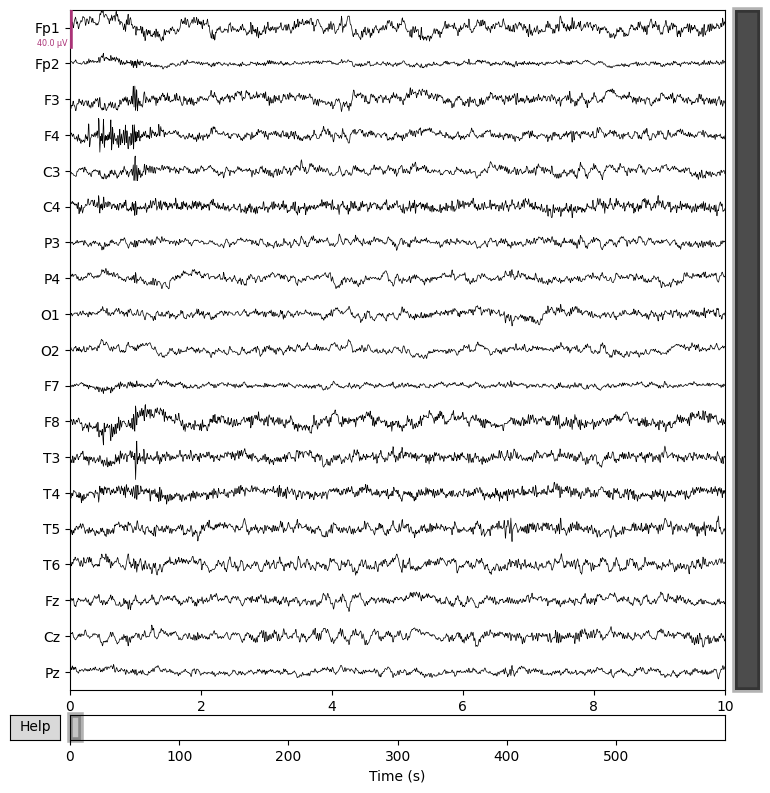

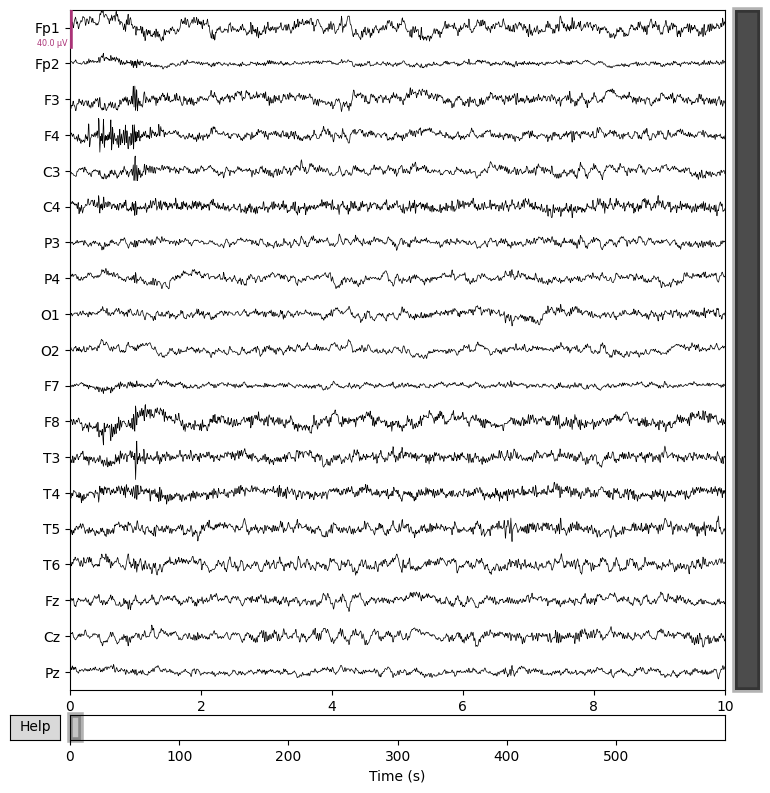

In [10]:
filtered_preprocessed = mne.io.read_raw_fif("/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-001_task-eyesclosed_eeg_preprocessed.fif", preload = True)

print (filtered_preprocessed.info)

filtered_preprocessed.plot()

## SECOND STEP:
#### -Feature Extraction 
#### i. Define a function to extract epochs
#### ii. Define a function to extract spectrum metrics
#### iii. Define a function to extract complexity metrics
#### iv. Define a function to extract synchronization metrics

##### i. Extracting 4-Second Epochs with 50% Overlap


In [11]:
def extract_epochs(raw, epoch_length, overlap):
    """
    Extract 4-second epochs with 50% overlap from the eeg data

    parameters:
    -raw: mne.io
    -epoch_length: length of each epoch in seconds, in this case it is 8 seconds
    -overlap: 50%

    returns:
    -epochs_data: array of shape (n_epochs, n_channels, n_samples)
    
    """
    s_freq = raw.info['sfreq'] #extracts the sampling frequency

    samples_per_epoch = int(epoch_length * s_freq) #convert epoch length to samples -this calculates the number of samples in one epoch

    step_size = int (samples_per_epoch * (1-overlap)) #how far to move forward for the next epoch

    #extract data

    data = raw.get_data()
    n_channels, n_samples = data.shape

    #create overlapping epochs

    epochs =  [] #initiate an empty list to store the extracted epochs
    for start in range(0, n_samples - samples_per_epoch + 1, step_size):
        epoch = data[:, start:start + samples_per_epoch] #extracts samples corresponding to the epoch length recall it is time samples(columns) we are epoching and selecting all channels(rows)
        epochs.append(epoch)

    epochs_data = np.array(epochs)
    return epochs_data



LET US START WITH THE FIRST PART, IMPLEMENTING THE EXTRACT EPOCHS FUNCTION AND LOOPING THROUGH MY FIF FILES

In [12]:
data_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed"
output_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap"


#looping through data folder

for file_name in os.listdir(data_folder):
    if file_name.endswith(".fif"):
        file_path = os.path.join(data_folder, file_name) #combines the folder path and the file name to get the full path

        print(f"Processing {file_name}...")

        #loading the fif preprocessed data

        raw = mne.io.read_raw_fif(file_path, preload=True)

        #calling the extract epoch function

        epochs_data = extract_epochs(raw, epoch_length=4, overlap = 0.5)

        # Save each epoch as a separate file
        subject_id = file_name.split('_')[0]  # Extract subject ID by splitting at the underscore and selecting the first index(e.g., sub-001)
        for i, epoch in enumerate(epochs_data):
            epoch_file = os.path.join(output_folder, f"{subject_id}_epoch-{i+1:03d}.npy")
            np.save(epoch_file, epoch)  # Save the epoch as a separate file

        print(f"Saved {len(epochs_data)} epochs for {file_name}") #prints the number of saved epochs for the current file



Processing sub-034_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-034_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-034_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 484949 =      0.000 ...   969.898 secs
Ready.
Reading 0 ... 484949  =      0.000 ...   969.898 secs...
Saved 483 epochs for sub-034_task-eyesclosed_eeg_preprocessed.fif
Processing sub-023_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-023_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 417369 =      0.000 ...   834.738 secs
Ready.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-023_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Reading 0 ... 417369  =      0.000 ...   834.738 secs...
Saved 416 epochs for sub-023_task-eyesclosed_eeg_preprocessed.fif
Processing sub-033_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-033_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-033_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 352709 =      0.000 ...   705.418 secs
Ready.
Reading 0 ... 352709  =      0.000 ...   705.418 secs...
Saved 351 epochs for sub-033_task-eyesclosed_eeg_preprocessed.fif
Processing sub-024_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-024_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-024_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 379899 =      0.000 ...   759.798 secs
Ready.
Reading 0 ... 379899  =      0.000 ...   759.798 secs...
Saved 378 epochs for sub-024_task-eyesclosed_eeg_preprocessed.fif
Processing sub-014_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-014_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-014_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 467219 =      0.000 ...   934.438 secs
Ready.
Reading 0 ... 467219  =      0.000 ...   934.438 secs...
Saved 466 epochs for sub-014_task-eyesclosed_eeg_preprocessed.fif
Processing sub-003_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-003_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-003_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 153049 =      0.000 ...   306.098 secs
Ready.
Reading 0 ... 153049  =      0.000 ...   306.098 secs...
Saved 152 epochs for sub-003_task-eyesclosed_eeg_preprocessed.fif
Processing sub-013_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-013_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 419049 =      0.000 ...   838.098 secs
Ready.
Reading 0 ... 419049  =      0.000 ...   838.098 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-013_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 418 epochs for sub-013_task-eyesclosed_eeg_preprocessed.fif
Processing sub-004_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-004_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 353049 =      0.000 ...   706.098 secs


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-004_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Ready.
Reading 0 ... 353049  =      0.000 ...   706.098 secs...
Saved 352 epochs for sub-004_task-eyesclosed_eeg_preprocessed.fif
Processing sub-064_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-064_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 424049 =      0.000 ...   848.098 secs
Ready.
Reading 0 ... 424049  =      0.000 ...   848.098 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-064_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 423 epochs for sub-064_task-eyesclosed_eeg_preprocessed.fif
Processing sub-063_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-063_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-063_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 402469 =      0.000 ...   804.938 secs
Ready.
Reading 0 ... 402469  =      0.000 ...   804.938 secs...
Saved 401 epochs for sub-063_task-eyesclosed_eeg_preprocessed.fif
Processing sub-044_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-044_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-044_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 440799 =      0.000 ...   881.598 secs
Ready.
Reading 0 ... 440799  =      0.000 ...   881.598 secs...
Saved 439 epochs for sub-044_task-eyesclosed_eeg_preprocessed.fif
Processing sub-053_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-053_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-053_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 390259 =      0.000 ...   780.518 secs
Ready.
Reading 0 ... 390259  =      0.000 ...   780.518 secs...
Saved 389 epochs for sub-053_task-eyesclosed_eeg_preprocessed.fif
Processing sub-043_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-043_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-043_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 414549 =      0.000 ...   829.098 secs
Ready.
Reading 0 ... 414549  =      0.000 ...   829.098 secs...
Saved 413 epochs for sub-043_task-eyesclosed_eeg_preprocessed.fif
Processing sub-054_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-054_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 418809 =      0.000 ...   837.618 secs
Ready.
Reading 0 ... 418809  =      0.000 ...   837.618 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-054_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 417 epochs for sub-054_task-eyesclosed_eeg_preprocessed.fif
Processing sub-015_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-015_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 450689 =      0.000 ...   901.378 secs
Ready.
Reading 0 ... 450689  =      0.000 ...   901.378 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-015_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 449 epochs for sub-015_task-eyesclosed_eeg_preprocessed.fif
Processing sub-002_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-002_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 396549 =      0.000 ...   793.098 secs
Ready.
Reading 0 ... 396549  =      0.000 ...   793.098 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-002_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 395 epochs for sub-002_task-eyesclosed_eeg_preprocessed.fif
Processing sub-012_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-012_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 441759 =      0.000 ...   883.518 secs
Ready.
Reading 0 ... 441759  =      0.000 ...   883.518 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-012_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 440 epochs for sub-012_task-eyesclosed_eeg_preprocessed.fif
Processing sub-005_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-005_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 402049 =      0.000 ...   804.098 secs
Ready.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-005_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Reading 0 ... 402049  =      0.000 ...   804.098 secs...
Saved 401 epochs for sub-005_task-eyesclosed_eeg_preprocessed.fif
Processing sub-035_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-035_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 370519 =      0.000 ...   741.038 secs


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-035_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Ready.
Reading 0 ... 370519  =      0.000 ...   741.038 secs...
Saved 369 epochs for sub-035_task-eyesclosed_eeg_preprocessed.fif
Processing sub-022_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-022_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-022_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 410959 =      0.000 ...   821.918 secs
Ready.
Reading 0 ... 410959  =      0.000 ...   821.918 secs...
Saved 409 epochs for sub-022_task-eyesclosed_eeg_preprocessed.fif
Processing sub-032_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-032_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 398889 =      0.000 ...   797.778 secs
Ready.
Reading 0 ... 398889  =      0.000 ...   797.778 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-032_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 397 epochs for sub-032_task-eyesclosed_eeg_preprocessed.fif
Processing sub-025_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-025_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 342179 =      0.000 ...   684.358 secs
Ready.
Reading 0 ... 342179  =      0.000 ...   684.358 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-025_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 341 epochs for sub-025_task-eyesclosed_eeg_preprocessed.fif
Processing sub-045_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-045_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 425819 =      0.000 ...   851.638 secs
Ready.
Reading 0 ... 425819  =      0.000 ...   851.638 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-045_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 424 epochs for sub-045_task-eyesclosed_eeg_preprocessed.fif
Processing sub-052_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-052_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 380049 =      0.000 ...   760.098 secs
Ready.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-052_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Reading 0 ... 380049  =      0.000 ...   760.098 secs...
Saved 379 epochs for sub-052_task-eyesclosed_eeg_preprocessed.fif
Processing sub-042_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-042_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 481509 =      0.000 ...   963.018 secs
Ready.
Reading 0 ... 481509  =      0.000 ...   963.018 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-042_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 480 epochs for sub-042_task-eyesclosed_eeg_preprocessed.fif
Processing sub-055_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-055_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 407299 =      0.000 ...   814.598 secs


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-055_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Ready.
Reading 0 ... 407299  =      0.000 ...   814.598 secs...
Saved 406 epochs for sub-055_task-eyesclosed_eeg_preprocessed.fif
Processing sub-065_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-065_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-065_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 442049 =      0.000 ...   884.098 secs
Ready.
Reading 0 ... 442049  =      0.000 ...   884.098 secs...
Saved 441 epochs for sub-065_task-eyesclosed_eeg_preprocessed.fif
Processing sub-062_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-062_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 449349 =      0.000 ...   898.698 secs
Ready.
Reading 0 ... 449349  =      0.000 ...   898.698 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-062_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 448 epochs for sub-062_task-eyesclosed_eeg_preprocessed.fif
Processing sub-058_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-058_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 378389 =      0.000 ...   756.778 secs
Ready.
Reading 0 ... 378389  =      0.000 ...   756.778 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-058_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 377 epochs for sub-058_task-eyesclosed_eeg_preprocessed.fif
Processing sub-048_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-048_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 494939 =      0.000 ...   989.878 secs
Ready.
Reading 0 ... 494939  =      0.000 ...   989.878 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-048_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 493 epochs for sub-048_task-eyesclosed_eeg_preprocessed.fif
Processing sub-008_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-008_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 396699 =      0.000 ...   793.398 secs
Ready.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-008_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Reading 0 ... 396699  =      0.000 ...   793.398 secs...
Saved 395 epochs for sub-008_task-eyesclosed_eeg_preprocessed.fif
Processing sub-018_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-018_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 422549 =      0.000 ...   845.098 secs
Ready.
Reading 0 ... 422549  =      0.000 ...   845.098 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-018_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 421 epochs for sub-018_task-eyesclosed_eeg_preprocessed.fif
Processing sub-028_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-028_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-028_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 409069 =      0.000 ...   818.138 secs
Ready.
Reading 0 ... 409069  =      0.000 ...   818.138 secs...
Saved 408 epochs for sub-028_task-eyesclosed_eeg_preprocessed.fif
Processing sub-038_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-038_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 445699 =      0.000 ...   891.398 secs
Ready.
Reading 0 ... 445699  =      0.000 ...   891.398 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-038_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 444 epochs for sub-038_task-eyesclosed_eeg_preprocessed.fif
Processing sub-059_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-059_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 393559 =      0.000 ...   787.118 secs
Ready.
Reading 0 ... 393559  =      0.000 ...   787.118 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-059_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 392 epochs for sub-059_task-eyesclosed_eeg_preprocessed.fif
Processing sub-049_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-049_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 390099 =      0.000 ...   780.198 secs
Ready.
Reading 0 ... 390099  =      0.000 ...   780.198 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-049_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 389 epochs for sub-049_task-eyesclosed_eeg_preprocessed.fif
Processing sub-029_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-029_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 368339 =      0.000 ...   736.678 secs
Ready.
Reading 0 ... 368339  =      0.000 ...   736.678 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-029_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 367 epochs for sub-029_task-eyesclosed_eeg_preprocessed.fif
Processing sub-039_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-039_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 425039 =      0.000 ...   850.078 secs
Ready.
Reading 0 ... 425039  =      0.000 ...   850.078 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-039_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 424 epochs for sub-039_task-eyesclosed_eeg_preprocessed.fif
Processing sub-009_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-009_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 306299 =      0.000 ...   612.598 secs
Ready.
Reading 0 ... 306299  =      0.000 ...   612.598 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-009_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 305 epochs for sub-009_task-eyesclosed_eeg_preprocessed.fif
Processing sub-019_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-019_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 459309 =      0.000 ...   918.618 secs
Ready.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-019_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Reading 0 ... 459309  =      0.000 ...   918.618 secs...
Saved 458 epochs for sub-019_task-eyesclosed_eeg_preprocessed.fif
Processing sub-010_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-010_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-010_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 640859 =      0.000 ...  1281.718 secs
Ready.
Reading 0 ... 640859  =      0.000 ...  1281.718 secs...
Saved 639 epochs for sub-010_task-eyesclosed_eeg_preprocessed.fif
Processing sub-007_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-007_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 383209 =      0.000 ...   766.418 secs


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-007_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Ready.
Reading 0 ... 383209  =      0.000 ...   766.418 secs...
Saved 382 epochs for sub-007_task-eyesclosed_eeg_preprocessed.fif
Processing sub-017_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-017_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 421699 =      0.000 ...   843.398 secs
Ready.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-017_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Reading 0 ... 421699  =      0.000 ...   843.398 secs...
Saved 420 epochs for sub-017_task-eyesclosed_eeg_preprocessed.fif
Processing sub-030_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-030_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 277039 =      0.000 ...   554.078 secs
Ready.
Reading 0 ... 277039  =      0.000 ...   554.078 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-030_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 276 epochs for sub-030_task-eyesclosed_eeg_preprocessed.fif
Processing sub-027_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-027_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-027_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 413099 =      0.000 ...   826.198 secs
Ready.
Reading 0 ... 413099  =      0.000 ...   826.198 secs...
Saved 412 epochs for sub-027_task-eyesclosed_eeg_preprocessed.fif
Processing sub-037_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-037_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 388549 =      0.000 ...   777.098 secs
Ready.
Reading 0 ... 388549  =      0.000 ...   777.098 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-037_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 387 epochs for sub-037_task-eyesclosed_eeg_preprocessed.fif
Processing sub-020_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-020_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 434649 =      0.000 ...   869.298 secs
Ready.
Reading 0 ... 434649  =      0.000 ...   869.298 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-020_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 433 epochs for sub-020_task-eyesclosed_eeg_preprocessed.fif
Processing sub-040_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-040_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-040_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 482869 =      0.000 ...   965.738 secs
Ready.
Reading 0 ... 482869  =      0.000 ...   965.738 secs...
Saved 481 epochs for sub-040_task-eyesclosed_eeg_preprocessed.fif
Processing sub-057_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-057_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 398249 =      0.000 ...   796.498 secs
Ready.
Reading 0 ... 398249  =      0.000 ...   796.498 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-057_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 397 epochs for sub-057_task-eyesclosed_eeg_preprocessed.fif
Processing sub-047_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-047_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 403499 =      0.000 ...   806.998 secs
Ready.
Reading 0 ... 403499  =      0.000 ...   806.998 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-047_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 402 epochs for sub-047_task-eyesclosed_eeg_preprocessed.fif
Processing sub-050_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-050_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 408819 =      0.000 ...   817.638 secs


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-050_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Ready.
Reading 0 ... 408819  =      0.000 ...   817.638 secs...
Saved 407 epochs for sub-050_task-eyesclosed_eeg_preprocessed.fif
Processing sub-060_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-060_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 374239 =      0.000 ...   748.478 secs
Ready.
Reading 0 ... 374239  =      0.000 ...   748.478 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-060_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 373 epochs for sub-060_task-eyesclosed_eeg_preprocessed.fif
Processing sub-031_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-031_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-031_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 575379 =      0.000 ...  1150.758 secs
Ready.
Reading 0 ... 575379  =      0.000 ...  1150.758 secs...
Saved 574 epochs for sub-031_task-eyesclosed_eeg_preprocessed.fif
Processing sub-026_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-026_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-026_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 449319 =      0.000 ...   898.638 secs
Ready.
Reading 0 ... 449319  =      0.000 ...   898.638 secs...
Saved 448 epochs for sub-026_task-eyesclosed_eeg_preprocessed.fif
Processing sub-036_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-036_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 420679 =      0.000 ...   841.358 secs
Ready.
Reading 0 ... 420679  =      0.000 ...   841.358 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-036_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 419 epochs for sub-036_task-eyesclosed_eeg_preprocessed.fif
Processing sub-021_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-021_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 460139 =      0.000 ...   920.278 secs
Ready.
Reading 0 ... 460139  =      0.000 ...   920.278 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-021_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 459 epochs for sub-021_task-eyesclosed_eeg_preprocessed.fif
Processing sub-011_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-011_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 384959 =      0.000 ...   769.918 secs
Ready.
Reading 0 ... 384959  =      0.000 ...   769.918 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-011_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 383 epochs for sub-011_task-eyesclosed_eeg_preprocessed.fif
Processing sub-006_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-006_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 316199 =      0.000 ...   632.398 secs
Ready.
Reading 0 ... 316199  =      0.000 ...   632.398 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-006_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 315 epochs for sub-006_task-eyesclosed_eeg_preprocessed.fif
Processing sub-016_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-016_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 486179 =      0.000 ...   972.358 secs
Ready.
Reading 0 ... 486179  =      0.000 ...   972.358 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-016_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 485 epochs for sub-016_task-eyesclosed_eeg_preprocessed.fif
Processing sub-001_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-001_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-001_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 299899 =      0.000 ...   599.798 secs
Ready.
Reading 0 ... 299899  =      0.000 ...   599.798 secs...
Saved 298 epochs for sub-001_task-eyesclosed_eeg_preprocessed.fif
Processing sub-061_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-061_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 401639 =      0.000 ...   803.278 secs
Ready.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-061_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Reading 0 ... 401639  =      0.000 ...   803.278 secs...
Saved 400 epochs for sub-061_task-eyesclosed_eeg_preprocessed.fif
Processing sub-041_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-041_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-041_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 443049 =      0.000 ...   886.098 secs
Ready.
Reading 0 ... 443049  =      0.000 ...   886.098 secs...
Saved 442 epochs for sub-041_task-eyesclosed_eeg_preprocessed.fif
Processing sub-056_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-056_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-056_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 395659 =      0.000 ...   791.318 secs
Ready.
Reading 0 ... 395659  =      0.000 ...   791.318 secs...
Saved 394 epochs for sub-056_task-eyesclosed_eeg_preprocessed.fif
Processing sub-046_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-046_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-046_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 376519 =      0.000 ...   753.038 secs
Ready.
Reading 0 ... 376519  =      0.000 ...   753.038 secs...
Saved 375 epochs for sub-046_task-eyesclosed_eeg_preprocessed.fif
Processing sub-051_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-051_task-eyesclosed_eeg_preprocessed.fif...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_95544/568684238.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_preprocessed/sub-051_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 376669 =      0.000 ...   753.338 secs
Ready.
Reading 0 ... 376669  =      0.000 ...   753.338 secs...
Saved 375 epochs for sub-051_task-eyesclosed_eeg_preprocessed.fif


Let us confirm the individual count if it tallies with what the paper says

In [13]:
#to get to the individual count and total number of epochs

# Initialize counters for AD and Healthy groups
ad_group_count = 0
healthy_group_count = 0

# Loop through all files in the folder
for file_name in os.listdir(output_folder):
    if file_name.endswith('.npy'):  # Process only .npy files
        subject_id = file_name.split('_')[0]  # Extract subject ID (e.g., 'sub-001')
        subject_num = int(subject_id.split('-')[1])  # Extract numerical part of the subject ID

        # Determine group and update counts
        if 1 <= subject_num <= 36:  # AD group
            ad_group_count += 1
        elif 37 <= subject_num <= 65:  # Healthy group
            healthy_group_count += 1

# Print group-level totals
print(f"AD Group: Total epochs: {ad_group_count}")
print(f"Healthy Group: Total epochs: {healthy_group_count}")
print("Total number of epochs", len(os.listdir(output_folder)))  # Total number of epochs


AD Group: Total epochs: 14514
Healthy Group: Total epochs: 12012
Total number of epochs 26526


## Signal Features Pipeline

##### ii. Extracting Spectrum Metrics:
##### -Mean
##### -Variance
##### -Interquartile Range
##### -Power Spectral Density

Step1: IQR, Mean, and Variance

In [14]:
def compute_basic_statistics(epoch):

    """
    Compute the basic statistics (mean, variance and interquartile range)for each channel in an epoch

    paramters:

    epoch: 2D array of shape (n_channels, n_samples) for one epoch

    returns:
    -stats_features: Dictionary with mean, variance and IQR values for each channel
    
    """
    n_channels = epoch.shape[0]
    stats_features = {}

    for ch_idx in range(n_channels): #looping through each channel
        #calculate mean
        mean_value = np.mean(epoch[ch_idx])
        stats_features[f"channel_{ch_idx}_mean"] = mean_value

        #calculate variance
        variance_value = np.var(epoch[ch_idx])
        stats_features[f"channel_{ch_idx}_variance"] = variance_value

        #calculate IQR
        IQR_value = np.percentile(epoch[ch_idx], 75) - np.percentile(epoch[ch_idx], 25)
        stats_features[f"channel_{ch_idx}_IQR"] = IQR_value
    return stats_features


Step 2: Power Spectral Density 

In [15]:
def compute_psd(epoch, sfreq):

    """
    Compute the Power Spectral Density (PSD) for the full frequency range (0.5-45 hz)
    Compute the Power Spectral Density (PSD) for each EEG rhythm in the frequency band

    Parameters:
    -epoch: 2D array of shape (n_channels, n_samples) for one epoch
    -sfreq; sampling frequency

    Returns:
    -psd_features: Dictionary with PSD values for each frequency band and channel   
    
    """

    n_channels, n_samples = epoch.shape
    psd_features = {} #an empty dictionary to store the results

    #define the bands as a dictionary, {band: (fmin, fmax)}
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 25),
        'gamma': (25, 45),


    }

    for ch_idx in range(n_channels):
        freqs, psd = welch(epoch[ch_idx], fs=sfreq, nperseg=n_samples)

        #extract PSD for the full frequency range
        psd_full_range = np.sum(psd[(freqs >=0.5) & (freqs <=45)]) #gets the total power within the full range
        psd_features[f"channel_{ch_idx}_psd_full"] = psd_full_range

        #extract PSD for each EEG rhythm (delta, theta, etc)

        for band, (fmin, fmax) in bands.items(): #iterating over the key and value
            band_power = np.sum(psd[(freqs >= fmin) & (freqs < fmax)]) #calculates total power for each band
            psd_features[f"channel_{ch_idx}_psd_{band}"] = band_power
            
    return psd_features

Step 3: Relative Band Power: This step normalizes the power in each frequency band relative to the total power

$$
\text{Relative Band Power} = \frac{\text{Power in Specific Band}}{\text{Total Power in All Bands}}
$$



In [16]:
def compute_relative_band_power(psd_features, n_channels):

    """
    Compute relative band power in each channel

    Parameters:

    -psd_features: a dictionary of PSD values for each band and channel
    -n_channels: number of EEG channels

    Returns:

    -relative band power: dictionary with relative power for each band and channel
    
    """

    relative_band_power = {}

    for ch_idx in range (n_channels):
        total_power = psd_features[f"channel_{ch_idx}_psd_full"]
        for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
            band_power = psd_features[f"channel_{ch_idx}_psd_{band}"]
            relative_band_power[f"channel_{ch_idx}_relative_{band}"] = band_power / total_power
            
    return relative_band_power

Step4: Combine all these metrics in one function to extract spectrum features

In [17]:
def extract_spectrum_features(epoch, sfreq):

    """
    Extract spectrum features: mean, variance, IQR, PSD and relative band power

    parameters

    epoch: 2D array of shape
    sfreq: sampling frequency

    returns:

    -features: Dictionary of spectrum features for each channel

    """

    n_channels = epoch.shape[0]
    features = {}

    #compute the time-domain metrics (Basic statistics)

    features.update(compute_basic_statistics(epoch))

    #compute psd
    psd_features = compute_psd(epoch, sfreq)
    features.update(psd_features)

    #compute relative band power
    relative_band_power = compute_relative_band_power(psd_features, n_channels)
    features.update(relative_band_power)

    return features

MOVING ON TO THE SECOND PART WHICH IS EXTRACTING SPECTRUM METRICS FROM THE EXTRACTED EPOCHS

In [18]:
spectrum_file_csv = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/spectrum.csv"
output_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap"
spectrum_features = []
sfreq = 500 

#looping through the epochs folder
for epochs_file in os.listdir(output_folder):
    if epochs_file.endswith('.npy'):

        #load the epochs
        epoch_path = os.path.join(output_folder, epochs_file) #this constructs the full path of the epoch folder
        epoch_data = np.load(epoch_path)

        #extract the spectrum features
        features = extract_spectrum_features(epoch_data, sfreq)

        # Add metadata (subject ID and epoch number)
        subject_id = epochs_file.split('_')[0]  # Extract subject ID (e.g., "sub-001")
        epoch_number = epochs_file.split('_')[1].replace('epoch-', '').split('.')[0]# Extract epoch number
        features['subject_id'] = subject_id
        features['epoch_number'] = int(epoch_number)

        #append the features to the list

        spectrum_features.append(features)

#convert the list to dataframe

spectrum_features_df = pd.DataFrame(spectrum_features)

#save to the csv file

spectrum_features_df.to_csv(spectrum_file_csv, index=False)

print(f"Spectrum features saved to {spectrum_file_csv}")




Spectrum features saved to /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/spectrum.csv


A brief check on the csv data

In [2]:
spectrum_raw_data = pd.read_csv("//Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/spectrum.csv")
spectrum_raw_data.head(5)

,channel_0_mean,channel_0_variance,channel_0_IQR,channel_1_mean,channel_1_variance,channel_1_IQR,channel_2_mean,channel_2_variance,channel_2_IQR,channel_3_mean,...,channel_17_relative_alpha,channel_17_relative_beta,channel_17_relative_gamma,channel_18_relative_delta,channel_18_relative_theta,channel_18_relative_alpha,channel_18_relative_beta,channel_18_relative_gamma,subject_id,epoch_number
0,-4.786864e-07,1.060292e-11,0.000005,-9.371691e-07,2.515001e-11,0.000007,-5.934128e-07,2.615504e-11,0.000007,-8.680908e-07,...,0.164940,0.204659,0.136004,0.286544,0.103876,0.195708,0.255853,0.155685,sub-019,42
1,1.258603e-06,1.700775e-11,0.000006,1.780468e-06,1.024151e-10,0.000016,-1.212468e-06,5.070587e-11,0.000012,2.685207e-07,...,0.511357,0.072129,0.009499,0.586124,0.045929,0.270105,0.085039,0.012729,sub-062,148
2,-3.234710e-08,5.425409e-12,0.000003,-9.267768e-08,3.625190e-12,0.000002,1.382835e-08,2.389978e-11,0.000007,-1.125982e-07,...,0.108518,0.125008,0.045404,0.544835,0.162288,0.098761,0.161509,0.032521,sub-034,331
3,-1.277939e-07,9.260228e-12,0.000004,-3.220071e-08,3.557287e-11,0.000008,9.606009e-08,4.308781e-11,0.000008,3.267711e-07,...,0.021615,0.071629,0.064838,0.622894,0.224906,0.070945,0.037110,0.043598,sub-030,52
4,1.823363e-07,2.436441e-12,0.000002,-1.038504e-07,2.398714e-12,0.000002,1.247647e-07,1.148268e-11,0.000005,-5.882811e-07,...,0.307545,0.132005,0.059976,0.335661,0.042155,0.507381,0.086378,0.028404,sub-038,162


#### iii. Extracting Complexity Metrics
#### - Approximate Entropy  
#### - Permutation Entropy
#### - Sample Entropy

In [3]:
complexity_file_csv = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/complex.csv"
output_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap"
sfreq = 500

In [4]:
def extract_entropy_features(epoch, subject_id, epoch_number):
    """
    Compute entropy features: Approximate Entropy, Sample Entropy,
    Permutation Entropy, and Multiscale Entropy for one epoch.

    Parameters:
    - epoch: 2D array (n_channels, n_samples) for the epoch
    - subject_id: ID of the subject
    - epoch_number: Epoch index number

    Returns:
    - features: Dictionary with entropy values for each channel and metadata
    """
    n_channels = epoch.shape[0]
    features = {
        "subject_id": subject_id,
        "epoch_number": epoch_number
    }

    for ch_idx in range(n_channels):
        channel_data = epoch[ch_idx]

        # Calculate Approximate Entropy (ApEn) and use the first value
        ap_en = ApEn(channel_data, m=2, r=0.15 * np.std(channel_data))[0]
        features[f"channel_{ch_idx}_ApEn"] = ap_en

        # Calculate Sample Entropy (SampEn) and use the first value
        samp_en = SampEn(channel_data, m=2, r=0.15 * np.std(channel_data))[0]
        features[f"channel_{ch_idx}_SampEn"] = samp_en

        # Calculate Permutation Entropy (PermEn) and use the first value
        perm_en = PermEn(channel_data, m=2, tau=5)[0]
        features[f"channel_{ch_idx}_PermEn"] = perm_en

    return features

In [5]:
# Precompute processed files upfront
if os.path.exists(complexity_file_csv) and os.path.getsize(complexity_file_csv) > 0:
    existing_df = pd.read_csv(complexity_file_csv)[['subject_id', 'epoch_number']]
    processed_set = set(
        (row['subject_id'], row['epoch_number']) for _, row in existing_df.iterrows()
    )
else:
    processed_set = set()

# List files to process
files_to_process = [
    f for f in os.listdir(output_folder) if f.endswith('.npy')
]

# Function definition
def process_epoch_file(epochs_file, output_folder, complexity_file_csv, processed_set):
    """
    Process a single epoch file to extract entropy features and append them to the CSV file.

    Parameters:
    - epochs_file: Path to the .npy epoch file
    - output_folder: Path to the folder containing epochs
    - complexity_file_csv: Path to the output CSV file
    - processed_set: Set of already processed (subject_id, epoch_number) tuples
    """
    epoch_path = os.path.join(output_folder, epochs_file)
    epoch_data = np.load(epoch_path)

    # Extract subject ID and epoch number
    subject_id = epochs_file.split('_')[0]  # Extract subject ID (e.g., "sub-001")
    epoch_number = int(epochs_file.split('_')[1].replace('epoch-', '').split('.')[0])  # Extract epoch number

    # Skip if the file has already been processed
    if (subject_id, epoch_number) in processed_set:
        print(f"Epoch {epoch_number} for subject {subject_id} already processed. Skipping...")
        return

    # Extract features
    features = extract_entropy_features(epoch_data, subject_id, epoch_number)

    # Append features to the CSV file
    features_df = pd.DataFrame([features])  # Convert to DataFrame
    if not os.path.isfile(complexity_file_csv) or os.path.getsize(complexity_file_csv) == 0:
        # Write with headers if file doesn't exist or is empty
        features_df.to_csv(complexity_file_csv, mode='w', index=False, header=True)
    else:
        # Append without headers if the file already exists and is not empty
        features_df.to_csv(complexity_file_csv, mode='a', index=False, header=False)


In [6]:

# Main processing
Parallel(n_jobs=-1)(
    delayed(process_epoch_file)(epochs_file, output_folder, complexity_file_csv, processed_set)
    for epochs_file in files_to_process
)

print(f"All entropy features saved to {complexity_file_csv}")


/Users/folasewaabdulsalam/Signal_Processing/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/folasewaabdulsalam/Signal_Processing/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/folasewaabdulsalam/Signal_Processing/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/folasewaabdulsalam/Signal_Processing/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: 

Epoch 42 for subject sub-019 already processed. Skipping...
Epoch 52 for subject sub-030 already processed. Skipping...
Epoch 148 for subject sub-062 already processed. Skipping...
Epoch 162 for subject sub-038 already processed. Skipping...
Epoch 331 for subject sub-034 already processed. Skipping...
Epoch 68 for subject sub-043 already processed. Skipping...
Epoch 211 for subject sub-015 already processed. Skipping...
Epoch 308 for subject sub-020 already processed. Skipping...
Epoch 88 for subject sub-056 already processed. Skipping...
Epoch 409 for subject sub-013 already processed. Skipping...
Epoch 191 for subject sub-063 already processed. Skipping...
Epoch 332 for subject sub-053 already processed. Skipping...
Epoch 228 for subject sub-001 already processed. Skipping...
Epoch 51 for subject sub-057 already processed. Skipping...
Epoch 238 for subject sub-028 already processed. Skipping...
Epoch 345 for subject sub-049 already processed. Skipping...
Epoch 36 for subject sub-064 

In [15]:
complexity_raw_data = pd.read_csv("/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/complex.csv")
complexity_raw_data.head(5)

,subject_id,epoch_number,channel_0_ApEn,channel_0_SampEn,channel_0_PermEn,channel_1_ApEn,channel_1_SampEn,channel_1_PermEn,channel_2_ApEn,channel_2_SampEn,...,channel_15_PermEn,channel_16_ApEn,channel_16_SampEn,channel_16_PermEn,channel_17_ApEn,channel_17_SampEn,channel_17_PermEn,channel_18_ApEn,channel_18_SampEn,channel_18_PermEn
0,sub-019,42,[2.61419085 1.15779268 0.70374048],[2.48047626 1.07164944 0.6992226 ],[-0. 0.99977797],[2.60910331 1.13638323 0.6948405 ],[2.45624481 1.05105816 0.69261122],[-0. 0.99992007],[2.61764596 1.46015712 0.72120365],[2.47469583 1.33369304 0.73408979],...,[-0. 0.99966486],[2.60604496 0.83532099 0.63450757],[2.46709523 0.75947593 0.58946262],[-0. 0.99928053],[2.60958002 0.95168533 0.66163644],[2.45937056 0.83439719 0.61657363],[-0. 0.99999112],[2.61251848 1.02009363 0.66699717],[2.47267758 0.94287506 0.64697126],[-0. 0.99928053]
1,sub-056,88,[2.58535548 0.64628583 0.58177427],[2.38824761 0.55639259 0.50565894],[-0. 0.99984757],[2.59525087 0.63708267 0.57807677],[2.41149255 0.56409149 0.51878163],[-0. 0.99903395],[2.60285953 0.61454025 0.57427709],[2.43502225 0.54446143 0.48791971],...,[-0. 0.99928053],[2.59183186 0.59599468 0.56815552],[2.42891884 0.53806249 0.5009366 ],[-0. 0.99886857],[2.5900066 0.6606454 0.57928967],[2.456029 0.61635106 0.53478258],[-0. 0.99990412],[2.60364256 0.65995359 0.58707527],[2.43980225 0.60008009 0.53176245],[-0. 0.99716624]
2,sub-038,162,[2.60229234 0.70946179 0.60432532],[2.44663109 0.64930259 0.55787444],[-0. 0.9995996],[2.61159178 0.72068849 0.60455481],[2.4669832 0.67959353 0.57836507],[-0. 0.99977797],[2.6070604 0.91426335 0.64426716],[2.46209528 0.81526536 0.60208363],...,[-0. 0.99995922],[2.6129583 0.81272992 0.62824845],[2.46485099 0.72522218 0.57215127],[-0. 0.99975187],[2.59951208 0.76449917 0.61879061],[2.45308229 0.69063043 0.5618278 ],[-0. 0.99994762],[2.59016382 0.5862948 0.56542341],[2.47543291 0.550381 0.51989989],[-0. 0.99966486]
3,sub-062,148,[2.58615905 0.36195266 0.44212576],[2.48628429 0.33793653 0.38984214],[-0. 0.99618603],[2.47267132 0.3097305 0.39653519],[2.34343835 0.29152558 0.34291906],[-0. 0.99869013],[2.58282747 0.48397951 0.52802357],[2.47050954 0.45070049 0.46792729],...,[-0. 0.99952854],[2.57988796 0.43974799 0.50215076],[2.48291164 0.43217062 0.46450807],[-0. 0.99945167],[2.56277138 0.27977456 0.36186896],[2.44252589 0.25709185 0.30446256],[-0. 0.99969531],[2.562514 0.36754765 0.44982247],[2.47185957 0.35860998 0.40923165],[-0. 0.99862774]
4,sub-011,172,[2.60142429 1.04963602 0.66489208],[2.43091884 0.92039449 0.63251246],[-0. 0.99977797],[2.6101831 1.05651049 0.68126071],[2.47810045 0.92462883 0.64631647],[-0. 0.99997807],[2.60726207 0.87052342 0.63475196],[2.45985051 0.76116845 0.58711858],...,[-0. 0.99975187],[2.60266755 0.58244746 0.56794496],[2.47359716 0.54688955 0.51791481],[-0. 0.99966486],[2.58401521 0.618155 0.57510967],[2.43701734 0.560857 0.51993213],[-0. 0.99988672],[2.61386859 0.60819347 0.57888591],[2.48387667 0.57394524 0.53409253],[-0. 0.99993457]


#### iv. Synchronization Metrics
#### -Clustering Coefficient
#### -characteristic path length
#### -efficiency
#### -small-worldness

To get synchronization metrics, first get the functional connectivity matrix, then threshold the matrix, build the graph and compute the metrics

Step 1: Functional Connectivity Matrix

In [7]:
def connectivity_matrix(epoch, method):
    """
    Compute the functional connectivity matrix for an epoch

    Parameters:
    -epoch: 2D numpy array (n_channels, n_samples_per_epoch)
    -method: synchronization method which can be pearson or phase locking value (plv)

    Returns:
    -connectivity_matrix: 2D numpy (n_channels, n_channels)

    """
    n_channels = epoch.shape[0]
    connectivity_matrix = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        for j in range(n_channels):
            if method == 'pearson': #for pearson method
                connectivity_matrix[i, j] = np.corrcoef(epoch[i, :], epoch[j, :])[0,1]

            elif method == 'plv':
                phase_i = np.angle(np.fft.fft(epoch[i, :])) #extract phases using fast fourier transform
                phase_j = np.angle(np.fft.fft(epoch[j, :]))
                phase_diff = phase_i - phase_j # instantaneous phase difference
                plv = np.abs(np.mean(np.exp(1j * phase_diff)))#plv
                connectivity_matrix[i, j] = plv
            
            else:
                raise ValueError("Invalid method of synchronization, choose either pearson or plv")

    return connectivity_matrix


Step 2: Threshold the connectivity matrix

In [8]:
#convert the functional connectivity matrix into a binary adjacency matrix

def threshold_matrix(connectivity_matrix, threshold ):
    """
    Threshold the functional connectivity matrix

    Parameters:
    -connectivity_matrix : 2D Numpy array (n_channels, n_channels)
    -threshold: proportion of strongest connection to keep (e.g 0.1 for 10%)

    Returns:
    -adjacency_matrix: 2D numpy array , binary matrix (0, 1) 

    """

    n_channels = connectivity_matrix.shape[0]
    #flatten and sort connections
    sorted_values = np.sort(connectivity_matrix.flatten())[::-1]
    cutoff = sorted_values[int(threshold * n_channels * n_channels)]
    
    #apply the threshold
    adjacency_matrix = (connectivity_matrix >=cutoff).astype(int)

    #remove self connections
    np.fill_diagonal(adjacency_matrix, 0)

    return adjacency_matrix
 

Step 3: Build the Graph and compute the graph metrics

In [9]:

def compute_graph_metrics(adjacency_matrix, n_swaps = None):
    """
    Compute the graph metrics from the adjacency matrix

    Parameters:
    -adjacency-matrix: 2D numpy array, binary matrix (0s and 1s)
    -n_swaps: nu,ber of edge swaps for null model. If none, defaults to 10 times the number of edges in the observed graphs

    Returns:
    -metrics: dict containing clustering coefficient, characteristic path length, global efficiency and small worldness
    
    """

    G = nx.from_numpy_array(adjacency_matrix)

    #compute the graph metrics
    clustering_coefficient = nx.average_clustering(G)

    try:
        path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        path_length = np.inf #handle disconnected graphs
    
    global_efficiency = nx.global_efficiency(G)

    #smallworldness = standardized clustering coefficients /  standardized characteristic path length

    #determine n_swaps if not provided
    n_edges = len(G.edges)
    if n_swaps is None:
        n_swaps = 10 * n_edges #default to 10 times th enumber of edges
    
    #create Null Model(shuffle edges)
    G_Null = G.copy()
    nx.double_edge_swap(G_Null, nswap = n_swaps, max_tries=n_swaps*10)

    #Null model metrics
    clustering_coefficient_null = nx.average_clustering(G_Null)

    try:
        path_length_null = nx.average_shortest_path_length(G_Null)
    except nx.NetworkXError:
        path_length_null = np.inf
    
    #compute the standardized metrics (Gamma and Delta)

    gamma = clustering_coefficient / clustering_coefficient_null if clustering_coefficient_null > 0 else 0
    delta = path_length / path_length_null if path_length_null > 0 else np.inf

    small_worldness = gamma/delta if delta > 0 else 0

    #return all the metrics

    metrics = {
        "clustering_coefficient": clustering_coefficient,
        "characteristic_path_length": path_length,
        "global_efficiency": global_efficiency,
        "small_worldness": small_worldness,

    }

    return metrics


Moving on the last part of feature extraction which is Synchronization Feature

In [10]:
def process_and_save_sync_epoch(file_path, csv_file, method, threshold):
    """
    Process a single epoch file, compute graph metrics, and write to a CSV file.

    Parameters:
    - file_path: Path to the .npy epoch file.
    - csv_file: Path to the CSV file to save results incrementally.
    - method: Synchronization method for connectivity matrix ('pearson' or 'plv').
    - threshold: Proportion of strongest connections to keep in adjacency matrix.
    """
    try:
        # Load the epoch data
        epoch = np.load(file_path)

        # Step 1: Compute the connectivity matrix
        connectivity = connectivity_matrix(epoch, method)

        # Step 2: Apply thresholding to create the adjacency matrix
        adjacency = threshold_matrix(connectivity, threshold)

        # Step 3: Compute graph metrics from the adjacency matrix
        metrics = compute_graph_metrics(adjacency)

        # Add metadata (subject ID and epoch number)
        file_name = os.path.basename(file_path)
        subject_id = file_name.split('_')[0]  # Extract subject ID
        epoch_number = file_name.split('_')[1].replace('epoch-', '').replace('.npy', '')  # Extract epoch number
        metrics['subject_id'] = subject_id
        metrics['epoch_number'] = int(epoch_number)

        # Convert metrics to a DataFrame
        df_metrics = pd.DataFrame([metrics])

        # Step 4: Write to the CSV file incrementally (append mode)
        write_header = not os.path.exists(csv_file) or os.path.getsize(csv_file) == 0  # Check if file is empty
        with open(csv_file, 'a') as f:
            df_metrics.to_csv(f, header=write_header, index=False)

        print(f"Processed and saved: {file_name}")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

In [ ]:
# Parameters
synchronization_method = "pearson"  # for pearson method
threshold_value = 0.6  # 60% strongest connections
graph_metrics_csv = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/synchronization.csv"
output_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap"  # Path to the folder containing .npy epoch files

# Check if the CSV file exists and is not empty
if os.path.exists(graph_metrics_csv) and os.path.getsize(graph_metrics_csv) > 0:
    processed_epochs = pd.read_csv(graph_metrics_csv)[['subject_id', 'epoch_number']]
    processed_set = set(
        (row['subject_id'], row['epoch_number']) for _, row in processed_epochs.iterrows()
    )
else:
    processed_set = set()

# List all files in the folder
epoch_files = [
    os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith(".npy")
]

# Filter out already processed files
files_to_process = []
for file_path in epoch_files:
    file_name = os.path.basename(file_path)
    subject_id = file_name.split('_')[0]
    epoch_number = int(file_name.split('_')[1].replace('epoch-', '').replace('.npy', ''))

    if (subject_id, epoch_number) not in processed_set:
        files_to_process.append(file_path)

print(f"{len(files_to_process)} epochs left to process.")

# Process remaining epochs in parallel
Parallel(n_jobs=-1)(
    delayed(process_and_save_sync_epoch)(
        file, graph_metrics_csv, synchronization_method, threshold_value
    )
    for file in files_to_process
)

print(f"All epochs processed and saved to {graph_metrics_csv}.")


25 epochs left to process.
Processed and saved: sub-013_epoch-346.npy
Processed and saved: sub-016_epoch-317.npy
Processed and saved: sub-016_epoch-316.npy
Error processing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap/sub-048_epoch-467.npy: Maximum number of swap attempts (900) exceeded before desired swaps achieved (90).
Processed and saved: sub-060_epoch-046.npy
Processed and saved: sub-016_epoch-265.npy
Processed and saved: sub-060_epoch-047.npy
Processed and saved: sub-023_epoch-027.npy
Processed and saved: sub-005_epoch-062.npy
Processed and saved: sub-050_epoch-379.npy
Processed and saved: sub-016_epoch-266.npy
Processed and saved: sub-005_epoch-059.npy
Processed and saved: sub-060_epoch-087.npy
Processed and saved: sub-016_epoch-072.npy
Processed and saved: sub-050_epoch-378.npy
Processed and saved: sub-048_epoch-444.npy
Processed and saved: sub-016_epoch-319.npy
Processed and saved: sub-016_epoch-071.npy
Processed and saved: sub-016_e

In [14]:
sync_data = pd.read_csv("/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/synchronization.csv")
sync_data.head(5)

,clustering_coefficient,characteristic_path_length,global_efficiency,small_worldness,subject_id,epoch_number
0,0.724659,1.421053,0.789474,1.366678,sub-019,42
1,0.736820,1.421053,0.789474,1.338261,sub-043,68
2,0.695232,1.421053,0.789474,1.330915,sub-062,148
3,0.684950,1.421053,0.789474,1.271628,sub-015,211
4,0.664248,1.421053,0.789474,1.186619,sub-034,331


In [19]:
#Complexity data is enclosed in a list

def extract_required_value(cell, metric_type):
    """
    Extract the required value based on the metric type.
    - ApEn and SampEn: Take the last value.
    - PermEn: Take the first value.
    """
    try:
    # Handle space-separated values in brackets (e.g., "[2.6 1.2 0.7]")
        if isinstance(cell, str) and "[" in cell and "]" in cell:
            values = [float(x) for x in cell.strip("[]").split()]
            return values[-1] if len(values) > 0 else np.nan  # Always return the last value
    
    # Handle string representations of arrays (e.g., "array([2.6, 1.2, 0.7])")
        elif isinstance(cell, str) and "array" in cell:
            start = cell.find("[")
            end = cell.find("]")
            if start != -1 and end != -1:
                values = [float(x) for x in cell[start + 1:end].split(",")]
                return values[-1] if len(values) > 0 else np.nan  # Always return the last value
    
    # If already numeric, return as-is
        return float(cell)
    except (ValueError, AttributeError):
     return np.nan  # Return NaN if extraction fails


In [20]:
def preprocess_entropy_metrics(df):
    """
    Process the DataFrame columns to extract the required values
    for ApEn, SampEn, and PermEn.
    """
    for col in df.columns:
        if "ApEn" in col:
            df[col] = df[col].apply(lambda x: extract_required_value(x, "ApEn"))
        elif "SampEn" in col:
            df[col] = df[col].apply(lambda x: extract_required_value(x, "SampEn"))
        elif "PermEn" in col:
            df[col] = df[col].apply(lambda x: extract_required_value(x, "PermEn"))
    return df

# Load your CSV file
df = pd.read_csv("/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/complex.csv")  # Replace with your file path

# Preprocess the entropy metrics
df = preprocess_entropy_metrics(df)

# Save the cleaned DataFrame to a new CSV file (optional)
df.to_csv("complexity_csv_file.csv", index=False)

In [21]:
complexity_data = pd.read_csv("/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/complexity_csv_file.csv")
complexity_data.head(5)

,subject_id,epoch_number,channel_0_ApEn,channel_0_SampEn,channel_0_PermEn,channel_1_ApEn,channel_1_SampEn,channel_1_PermEn,channel_2_ApEn,channel_2_SampEn,...,channel_15_PermEn,channel_16_ApEn,channel_16_SampEn,channel_16_PermEn,channel_17_ApEn,channel_17_SampEn,channel_17_PermEn,channel_18_ApEn,channel_18_SampEn,channel_18_PermEn
0,sub-019,42,0.703740,0.699223,0.999778,0.694840,0.692611,0.999920,0.721204,0.734090,...,0.999665,0.634508,0.589463,0.999281,0.661636,0.616574,0.999991,0.666997,0.646971,0.999281
1,sub-056,88,0.581774,0.505659,0.999848,0.578077,0.518782,0.999034,0.574277,0.487920,...,0.999281,0.568156,0.500937,0.998869,0.579290,0.534783,0.999904,0.587075,0.531762,0.997166
2,sub-038,162,0.604325,0.557874,0.999600,0.604555,0.578365,0.999778,0.644267,0.602084,...,0.999959,0.628248,0.572151,0.999752,0.618791,0.561828,0.999948,0.565423,0.519900,0.999665
3,sub-062,148,0.442126,0.389842,0.996186,0.396535,0.342919,0.998690,0.528024,0.467927,...,0.999529,0.502151,0.464508,0.999452,0.361869,0.304463,0.999695,0.449822,0.409232,0.998628
4,sub-011,172,0.664892,0.632512,0.999778,0.681261,0.646316,0.999978,0.634752,0.587119,...,0.999752,0.567945,0.517915,0.999665,0.575110,0.519932,0.999887,0.578886,0.534093,0.999935


CLASSIFICATION MODEL BUILDING

In [22]:
#import the libraries
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix


In [23]:
#combining all the csv files to form one dataset
combined_data = pd.merge(spectrum_raw_data, complexity_data, on = ['subject_id', 'epoch_number'])
raw_data = pd.merge(combined_data, sync_data, on = ['subject_id', 'epoch_number']) 

In [24]:
raw_data.head(5)

,channel_0_mean,channel_0_variance,channel_0_IQR,channel_1_mean,channel_1_variance,channel_1_IQR,channel_2_mean,channel_2_variance,channel_2_IQR,channel_3_mean,...,channel_17_ApEn,channel_17_SampEn,channel_17_PermEn,channel_18_ApEn,channel_18_SampEn,channel_18_PermEn,clustering_coefficient,characteristic_path_length,global_efficiency,small_worldness
0,-4.786864e-07,1.060292e-11,0.000005,-9.371691e-07,2.515001e-11,0.000007,-5.934128e-07,2.615504e-11,0.000007,-8.680908e-07,...,0.661636,0.616574,0.999991,0.666997,0.646971,0.999281,0.724659,1.421053,0.789474,1.366678
1,1.258603e-06,1.700775e-11,0.000006,1.780468e-06,1.024151e-10,0.000016,-1.212468e-06,5.070587e-11,0.000012,2.685207e-07,...,0.361869,0.304463,0.999695,0.449822,0.409232,0.998628,0.695232,1.421053,0.789474,1.330915
2,-3.234710e-08,5.425409e-12,0.000003,-9.267768e-08,3.625190e-12,0.000002,1.382835e-08,2.389978e-11,0.000007,-1.125982e-07,...,0.604324,0.560903,0.999633,0.605988,0.568798,1.000000,0.664248,1.421053,0.789474,1.186619
3,-1.277939e-07,9.260228e-12,0.000004,-3.220071e-08,3.557287e-11,0.000008,9.606009e-08,4.308781e-11,0.000008,3.267711e-07,...,0.360432,0.322915,0.996887,0.398440,0.359834,0.999724,0.650566,1.421053,0.789474,1.172897
4,1.823363e-07,2.436441e-12,0.000002,-1.038504e-07,2.398714e-12,0.000002,1.247647e-07,1.148268e-11,0.000005,-5.882811e-07,...,0.618791,0.561828,0.999948,0.565423,0.519900,0.999665,0.653884,1.421053,0.789474,1.208126


In [25]:
#creating a new column titled label 0 for CN, 1 for AZ
#AD Group: Sub 001 to sub 036
#CN Group: Sub 037 to sub 065

def assign_label(subject_id):
    subject_num = int(subject_id.split('-')[1])
    if subject_num in range(1,37):
        return 1
    elif subject_num in range(37, 66):
        return 0
    else:
        return None

raw_data['label'] = raw_data['subject_id'].apply(assign_label)

raw_data.to_csv('dataset_project_ds.csv', index=False) #to save the updated data

In [26]:
raw_data['label'].value_counts()

label
1    14514
0    12011
Name: count, dtype: int64

In [27]:
#cleaning the data
# Select only numeric columns for processing
numeric_cols = raw_data.select_dtypes(include=[np.number]).columns

# Remove rows with inf or -inf in numeric columns
raw_data = raw_data[~np.isinf(raw_data[numeric_cols]).any(axis=1)]

# Remove rows with NaN in the dataset
raw_data = raw_data.dropna()


In [28]:
X = raw_data.drop(['label', 'subject_id', 'epoch_number'], axis = 1)
y = raw_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)


In [29]:
#functions for model building
def train_evaluate_decision_tree(X_train, X_test, y_train, y_test):

    print("\n.....training and evaluating with Decision Tree....")
    dt_model = DecisionTreeClassifier(random_state=42, 
                                      class_weight='balanced', 
                                      max_depth=5, min_samples_split=5, min_samples_leaf=5)
    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    accuracy =accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, pos_label=1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn/(tn+fp)

    #printing these metrics
    print("Decision Tree Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return dt_model

def train_evaluate_random_forest(X_train, X_test, y_train, y_test):

    print("\n ... training and evaluating with Random Forest ...")

    rf_model = RandomForestClassifier(n_estimators= 100, 
                                      max_depth=10,
                                      min_samples_split=5,
                                      min_samples_leaf=2,
                                      class_weight='balanced',
                                      random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy =accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, pos_label=1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn/(tn+fp)

    #printing these metrics
    print("Random Forest Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return rf_model

def train_evaluate_svm(X_train, X_test, y_train, y_test):

    print("\n...training and evaluating with svm ...")

    svm_model = SVC(random_state=42, class_weight='balanced', kernel="linear")
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    accuracy =accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, pos_label=1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn/(tn+fp)
    

    #printing these metrics
    print("SVM  Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    

    return svm_model

def train_evaluate_lightgbm(X_train, X_test, y_train, y_test):

    print("\n...training and evaluating with lightgbm...")
    lgb_model = lgb.LGBMClassifier(n_estimators=100,
                                   class_weight="balanced",scale_pos_weight=619 / 397,random_state=42)
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, pos_label=1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn/(tn+fp)

    # Print metrics
    print("LightGBM Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return lgb_model


In [30]:
dt_model = train_evaluate_decision_tree(X_train, X_test, y_train, y_test)
rf_model = train_evaluate_random_forest(X_train, X_test, y_train, y_test)
svm_model = train_evaluate_svm(X_train, X_test, y_train, y_test)
light_model = train_evaluate_lightgbm(X_train, X_test, y_train, y_test)


.....training and evaluating with Decision Tree....
Decision Tree Performance Metrics:
Accuracy: 0.8353
Sensitivity (Recall): 0.7775
Specificity: 0.9045

 ... training and evaluating with Random Forest ...
Random Forest Performance Metrics:
Accuracy: 0.9457
Sensitivity (Recall): 0.9414
Specificity: 0.9508

...training and evaluating with svm ...
SVM  Performance Metrics:
Accuracy: 0.8628
Sensitivity (Recall): 0.8503
Specificity: 0.8778

...training and evaluating with lightgbm...
[LightGBM] [Info] Number of positive: 2911, number of negative: 2352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79662
[LightGBM] [Info] Number of data points in the train set: 5263, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LightGBM Performance 

CROSS VALIDATION USING GroupShuffleSplit

In [31]:
# Features and labels
features = raw_data.drop(['label', 'subject_id', 'epoch_number'], axis=1)
label_column = 'label'
X = features
y = raw_data[label_column]
groups = raw_data['subject_id']


## Initialize dictionaries to store metrics for each model
dt_metrics = {'accuracy': [], 'sensitivity': [], 'specificity': []}
rf_metrics = {'accuracy': [], 'sensitivity': [], 'specificity': []}
svm_metrics = {'accuracy': [], 'sensitivity': [], 'specificity': []}
lgb_metrics = {'accuracy': [], 'sensitivity': [], 'specificity': []}

# GroupShuffleSplit instance
group_splitter = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Iterate through the splits
for fold_idx, (train_idx, test_idx) in enumerate(group_splitter.split(X, y, groups=groups)):
    # Split data into train and test sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Ensure both classes are present in the test set
    if len(y_test.unique()) < 2:
        print(f"Skipping Fold {fold_idx + 1}: Test set does not contain both classes.")
        continue

    print(f"\n--- Fold {fold_idx + 1} ---")

    # Decision Tree
    dt_model = train_evaluate_decision_tree(X_train, X_test, y_train, y_test)
    dt_metrics['accuracy'].append(accuracy_score(y_test, dt_model.predict(X_test)))
    dt_metrics['sensitivity'].append(recall_score(y_test, dt_model.predict(X_test), pos_label=1))
    tn, fp, fn, tp = confusion_matrix(y_test, dt_model.predict(X_test)).ravel()
    dt_metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    # Random Forest
    rf_model = train_evaluate_random_forest(X_train, X_test, y_train, y_test)
    rf_metrics['accuracy'].append(accuracy_score(y_test, rf_model.predict(X_test)))
    rf_metrics['sensitivity'].append(recall_score(y_test, rf_model.predict(X_test), pos_label=1))
    tn, fp, fn, tp = confusion_matrix(y_test, rf_model.predict(X_test)).ravel()
    rf_metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    # SVM
    svm_model = train_evaluate_svm(X_train, X_test, y_train, y_test)
    svm_metrics['accuracy'].append(accuracy_score(y_test, svm_model.predict(X_test)))
    svm_metrics['sensitivity'].append(recall_score(y_test, svm_model.predict(X_test), pos_label=1))
    tn, fp, fn, tp = confusion_matrix(y_test, svm_model.predict(X_test)).ravel()
    svm_metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    #lightgbm
    lgb_model = train_evaluate_lightgbm(X_train, X_test, y_train, y_test)
    lgb_metrics['accuracy'].append(accuracy_score(y_test, lgb_model.predict(X_test)))
    lgb_metrics['sensitivity'].append(recall_score(y_test, lgb_model.predict(X_test), pos_label=1))
    tn, fp, fn, tp = confusion_matrix(y_test, lgb_model.predict(X_test)).ravel()
    lgb_metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

# Print Average Metrics Across All Folds
print("\n--- Average Metrics Across All Folds ---")

# Decision Tree
print("Decision Tree:")
print(f"Average Accuracy: {sum(dt_metrics['accuracy']) / len(dt_metrics['accuracy']):.4f}")
print(f"Average Sensitivity: {sum(dt_metrics['sensitivity']) / len(dt_metrics['sensitivity']):.4f}")
print(f"Average Specificity: {sum(dt_metrics['specificity']) / len(dt_metrics['specificity']):.4f}")

# Random Forest
print("\nRandom Forest:")
print(f"Average Accuracy: {sum(rf_metrics['accuracy']) / len(rf_metrics['accuracy']):.4f}")
print(f"Average Sensitivity: {sum(rf_metrics['sensitivity']) / len(rf_metrics['sensitivity']):.4f}")
print(f"Average Specificity: {sum(rf_metrics['specificity']) / len(rf_metrics['specificity']):.4f}")

# SVM
print("\nSVM:")
print(f"Average Accuracy: {sum(svm_metrics['accuracy']) / len(svm_metrics['accuracy']):.4f}")
print(f"Average Sensitivity: {sum(svm_metrics['sensitivity']) / len(svm_metrics['sensitivity']):.4f}")
print(f"Average Specificity: {sum(svm_metrics['specificity']) / len(svm_metrics['specificity']):.4f}")

# Lightgbm
print("\nLightGBM:")
print(f"Average Accuracy: {sum(lgb_metrics['accuracy']) / len(lgb_metrics['accuracy']):.4f}")
print(f"Average Sensitivity: {sum(lgb_metrics['sensitivity']) / len(lgb_metrics['sensitivity']):.4f}")
print(f"Average Specificity: {sum(lgb_metrics['specificity']) / len(lgb_metrics['specificity']):.4f}")





--- Fold 1 ---

.....training and evaluating with Decision Tree....
Decision Tree Performance Metrics:
Accuracy: 0.6049
Sensitivity (Recall): 0.5161
Specificity: 0.7132

 ... training and evaluating with Random Forest ...
Random Forest Performance Metrics:
Accuracy: 0.6338
Sensitivity (Recall): 0.5842
Specificity: 0.6944

...training and evaluating with svm ...
SVM  Performance Metrics:
Accuracy: 0.6412
Sensitivity (Recall): 0.6356
Specificity: 0.6481

...training and evaluating with lightgbm...
[LightGBM] [Info] Number of positive: 11271, number of negative: 9382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80039
[LightGBM] [Info] Number of data points in the train set: 20653, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Lig

#### Visualization(Results)

Frequency Domain Analyses of the Resting -state EEG for CN and AD subjects

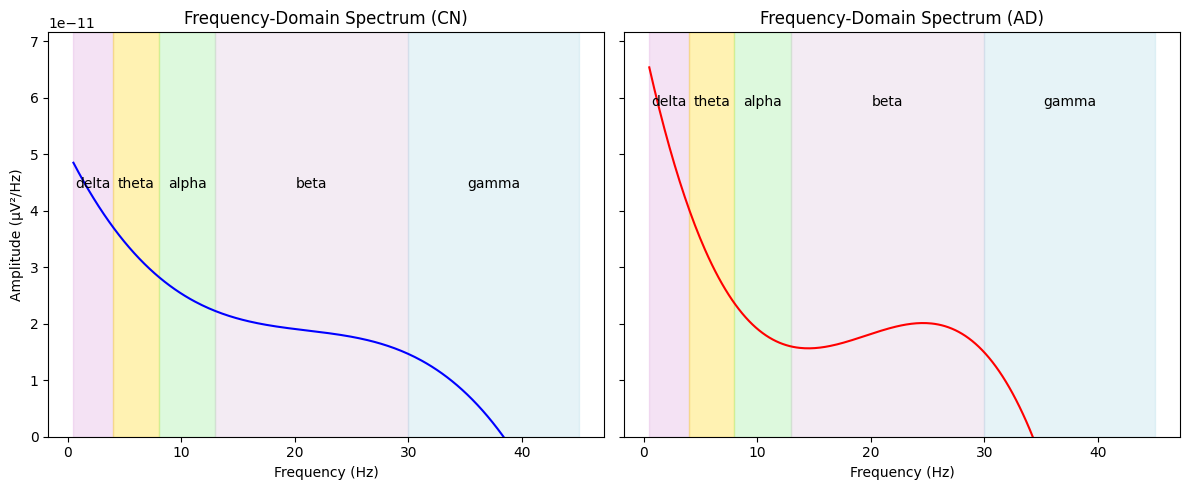

In [36]:
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# Define frequency bands and their actual ranges
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
band_edges = [0.5, 4, 8, 13, 30, 45]  # Start of each band + last value for gamma
colors = ['#DDA0DD', '#FFD700', '#90EE90', '#D8BFD8', '#ADD8E6']  # Colors for shading

# Separate CN and AD groups
cn_group = raw_data[raw_data['label'] == 0]
ad_group = raw_data[raw_data['label'] == 1]

# Compute mean PSD per frequency band for CN and AD
cn_psd_means = [cn_group[[col for col in cn_group.columns if f'psd_{band}' in col]].mean(axis=1).mean()
                for band in frequency_bands]
ad_psd_means = [ad_group[[col for col in ad_group.columns if f'psd_{band}' in col]].mean(axis=1).mean()
                for band in frequency_bands]

# Apply Gaussian smoothing to PSD values before interpolation
cn_psd_smooth = gaussian_filter1d(cn_psd_means, sigma=1)
ad_psd_smooth = gaussian_filter1d(ad_psd_means, sigma=1)

# Interpolation for smooth curve
smooth_freq = np.linspace(band_edges[0], band_edges[-1], 300)
cn_spline = UnivariateSpline(band_edges[:-1], cn_psd_smooth, s=0.5)  # Match length of cn_psd_smooth
ad_spline = UnivariateSpline(band_edges[:-1], ad_psd_smooth, s=0.5)

# Plot CN vs AD frequency-domain spectrum
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# CN Plot
axes[0].plot(smooth_freq, cn_spline(smooth_freq), color='b', label="CN Mean PSD")
for i in range(len(frequency_bands)):  
    axes[0].axvspan(band_edges[i], band_edges[i+1], color=colors[i], alpha=0.3)
    axes[0].text((band_edges[i] + band_edges[i+1]) / 2, max(cn_psd_smooth) * 0.9, frequency_bands[i], fontsize=10, ha='center')
axes[0].set_title("Frequency-Domain Spectrum (CN)")
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Amplitude (µV²/Hz)")
axes[0].set_ylim(0, max(max(cn_psd_smooth), max(ad_psd_smooth)) * 1.1)  
axes[0].set_xticks([0, 10, 20, 30, 40])

# AD Plot
axes[1].plot(smooth_freq, ad_spline(smooth_freq), color='r', label="AD Mean PSD")
for i in range(len(frequency_bands)):  
    axes[1].axvspan(band_edges[i], band_edges[i+1], color=colors[i], alpha=0.3)
    axes[1].text((band_edges[i] + band_edges[i+1]) / 2, max(ad_psd_smooth) * 0.9, frequency_bands[i], fontsize=10, ha='center')
axes[1].set_title("Frequency-Domain Spectrum (AD)")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylim(0, max(max(cn_psd_smooth), max(ad_psd_smooth)) * 1.1)  
axes[1].set_xticks([0, 10, 20, 30, 40])

plt.tight_layout()
plt.show()


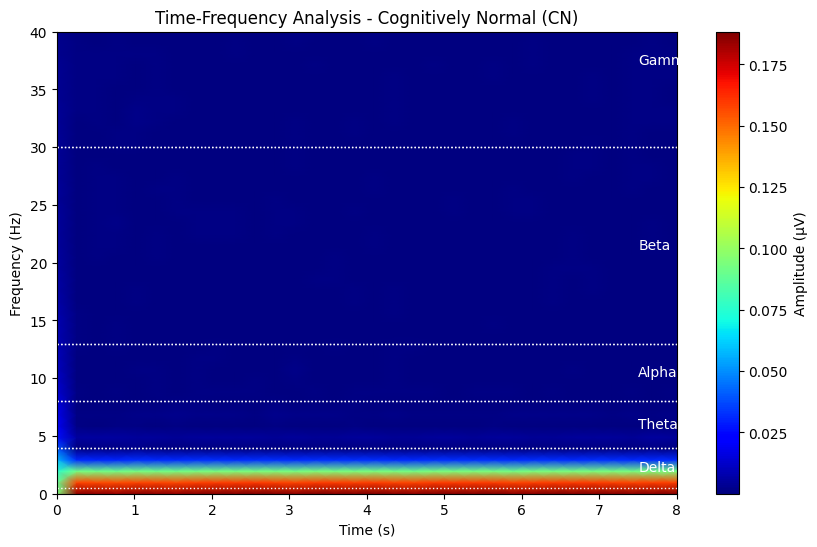

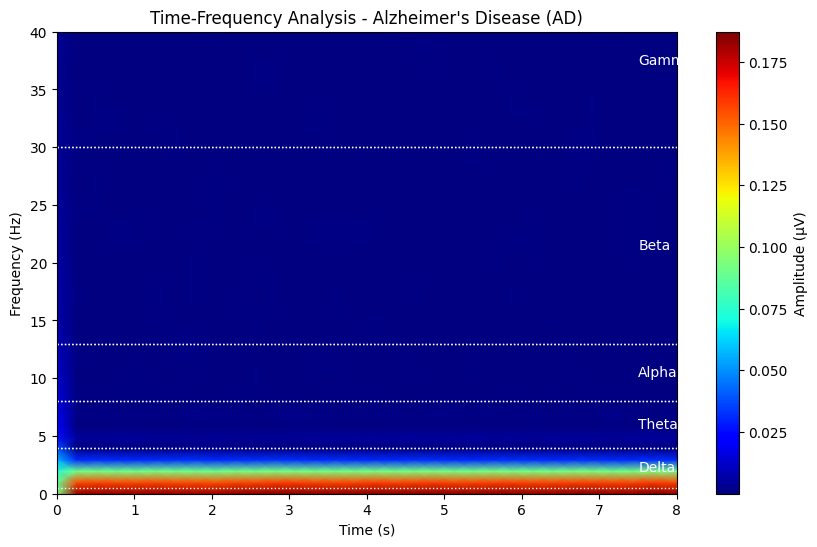

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

# Define EEG frequency bands
frequency_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30), 'Gamma': (30, 45)}
colors = ['#E6CCFF', '#FFE599', '#B6D7A8', '#D5A6BD', '#CFE2F3']

# Set EEG sampling frequency (Hz)
fs = 500  

# Define frontal channels
frontal_channels = ["channel_0", "channel_1", "channel_2", "channel_3"]  # Modify based on actual dataset

# Extract and average EEG signals from frontal channels
cn_eeg = raw_data[raw_data['label'] == 0][[col for col in raw_data.columns if any(ch in col for ch in frontal_channels)]].mean(axis=1).to_numpy()
ad_eeg = raw_data[raw_data['label'] == 1][[col for col in raw_data.columns if any(ch in col for ch in frontal_channels)]].mean(axis=1).to_numpy()

# inputting nperseg and noverlap parameters
nperseg = min(256, len(cn_eeg) // 4) 
noverlap = max(nperseg // 2, 1)  

# Function to compute and plot STFT spectrogram with proper scaling
def plot_stft(eeg_data, fs, title):
    f, t, Zxx = signal.stft(eeg_data, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=512, window='hann')

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='jet')  #'gouraud' for smoother interpolation
    plt.colorbar(label="Amplitude (µV)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(f"Time-Frequency Analysis - {title}")

    # Set the axis range 
    plt.xlim(0, 8)  
    plt.ylim(0, 40)  

    # dotted lines and band labels
    for (band, (low, high)), color in zip(frequency_bands.items(), colors):
        plt.axhline(y=low, color='white', linestyle='dotted', linewidth=1)
        plt.axhline(y=high, color='white', linestyle='dotted', linewidth=1)
        plt.text(7.5, (low + high) / 2, band, fontsize=10, color='white', verticalalignment='center')

    plt.show()

# Plot Time-Frequency Analysis for CN and AD EEG Signals
plot_stft(cn_eeg, fs, "Cognitively Normal (CN)")
plot_stft(ad_eeg, fs, "Alzheimer's Disease (AD)")


T-test

In [33]:
import scipy.stats as stats

# Define feature categories
time_domain_features = ['mean', 'variance', 'IQR']
freq_domain_features = ['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma']
complexity_features = ['ApEn', 'PermEn', 'SampEn']  
sync_features = ['clustering_coefficient', 'characteristic_path_length', 'global_efficiency', 'small_worldness']

# Separate CN and AD groups
cn_group = raw_data[raw_data['label'] == 0]
ad_group = raw_data[raw_data['label'] == 1]

# Function to compute t-tests and interpret trends
def compute_t_tests(features, cn_group, ad_group):
    results = []
    for feature in features:
        cn_values = cn_group[[col for col in cn_group.columns if feature in col]].mean().dropna()
        ad_values = ad_group[[col for col in ad_group.columns if feature in col]].mean().dropna()
        
        if len(cn_values) > 1 and len(ad_values) > 1:
            t_stat, p_val = stats.ttest_ind(cn_values, ad_values, equal_var=False)
        else:
            p_val = np.nan
        
        cn_mean = cn_values.mean()
        ad_mean = ad_values.mean()
        trend = "Increase" if ad_mean > cn_mean else "Decrease"
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "Not Significant"
        
        results.append([feature, cn_mean, ad_mean, trend, p_val, significance])
    
    return pd.DataFrame(results, columns=["Feature", "CN Mean", "AD Mean", "Trend", "p-value", "Significance"])

# Perform t-tests separately for each feature category
time_results = compute_t_tests(time_domain_features, cn_group, ad_group)
freq_results = compute_t_tests(freq_domain_features, cn_group, ad_group)
complexity_results = compute_t_tests(complexity_features, cn_group, ad_group)
sync_results = compute_t_tests(sync_features, cn_group, ad_group)

# Display the results
def print_results(title, df):
    print(f"\n### {title} ###\n")
    print(df.to_string(index=False))

print_results("Time-Domain Metrics", time_results)
print_results("Frequency-Domain Metrics", freq_results)
print_results("Complexity Metrics", complexity_results)
print_results("Synchronization Metrics", sync_results)


### Time-Domain Metrics ###

 Feature      CN Mean       AD Mean    Trend  p-value    Significance
    mean 4.905018e-16 -1.960685e-15 Decrease 0.999994 Not Significant
variance 4.217597e-11  4.375970e-11 Increase 0.679338 Not Significant
     IQR 7.312333e-06  7.180487e-06 Decrease 0.676574 Not Significant

### Frequency-Domain Metrics ###

  Feature      CN Mean      AD Mean    Trend      p-value    Significance
psd_delta 6.691838e-11 8.888641e-11 Increase 1.155588e-02               *
psd_theta 1.085541e-11 2.324865e-11 Increase 1.575417e-08             ***
psd_alpha 4.496869e-11 1.929056e-11 Decrease 2.743778e-04             ***
 psd_beta 1.722928e-11 1.365416e-11 Decrease 2.816675e-02               *
psd_gamma 1.070194e-11 1.499866e-11 Increase 1.038964e-01 Not Significant

### Complexity Metrics ###

Feature  CN Mean  AD Mean    Trend  p-value Significance
   ApEn 0.606673 0.591250 Decrease 0.018695            *
 PermEn 0.999512 0.999569 Increase 0.026755            *
 SampEn 0.5